In [3]:
import sys
sys.path.append("../..") # The notebooks are located in a folder next to the library modules
import importlib

import os
import pyvista as pv

from pypho.design import target, graphics, camera
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import colors

In [107]:
importlib.reload(camera)
importlib.reload(target)
importlib.reload(graphics)

<module 'pypho.design.graphics' from 'c:\\Users\\glaurent\\Documents\\Dev\\Projects\\PhotogrammetryTools\\notebooks\\01_photogrammetric_design\\../..\\pypho\\design\\graphics.py'>

# Dev colormaps

In [110]:
obj, cam, viewer = graphics.get_default_scene(show= False)
cam.move_to(1, "distance")
cam.update_aperture()
cam.focus_on(obj.center)
viewer.show(show_shots= True, show_cameras= True)
cam.trigger(add_to_viewer= False)

Widget(value='<iframe src="http://localhost:49508/index.html?ui=P_0x1d17602e050_9&reconnect=auto" class="pyvis…

In [96]:
cam.move_to(2, "distance")
viewer.update()

In [103]:
cam.confusion_circle_diameter*1000

np.float64(7.437500000000001)

In [98]:
obj.point_data["blur_spot_diameter"].min()

np.float64(5.164661502)

In [99]:
obj.point_data["defocus_diameter"].min()

np.float64(0.0)

In [108]:
viewer.set_active_scalars("blur_spot_diameter",  cmap= graphics.BlurSpotDiameterColormap(cam=cam, obj= obj))

In [109]:
viewer.set_active_scalars("defocus_diameter", vmin=0,
                          cmap= graphics.BlurSpotDiameterColormap(cam=cam, obj= obj, vmin=0, field= "defocus_diameter"))

in: 17  out: 239


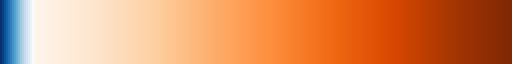

In [75]:
field_name = "blur_spot_diameter"
n_in = min(255, 1 + round(255 * cam.confusion_circle_diameter * 1000 / obj.point_data[field_name].max()))
n_out = 256 - n_in

print("in:",n_in," out:",n_out)

out_cmap = mpl.colormaps['Oranges'].resampled(n_out)
in_cmap = mpl.colormaps['Blues_r'].resampled(n_in)

combined_colors = np.vstack((
    in_cmap(np.linspace(0,1, n_in)),
    out_cmap(np.linspace(0,1, n_out))
))
combined_cmap = colors.ListedColormap(combined_colors, "Zone")

combined_cmap


In [36]:
viewer.set_active_scalars("blur_spot_diameter", cmap= combined_cmap)

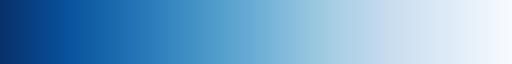

In [86]:
graphics.ZoneColormap(cam.confusion_circle_diameter*1000,
                      0, obj.point_data["blur_spot_diameter"].max()
                      )

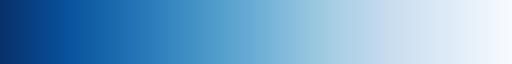

In [87]:
blur_cmap = graphics.BlurSpotDiameterColormap(cam=cam, obj=obj)
blur_cmap

In [88]:
cam.move_to(0.5, "distance")

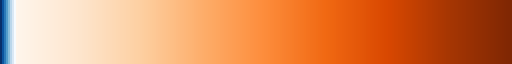

In [89]:
blur_cmap.update()
blur_cmap

# test loading and using models

In [29]:
dir = r"..\..\datasets\scheelite"
source = os.path.join(dir,"scheelite.obj")
pv_obj = pv.read(source)
obj = target.TargetObject(pv_obj)
texture = pv.read_texture(os.path.join(dir,"scheelite.jpg"))

cam = camera.get_default_camera()
cam.init_location(obj)
cam.attach_target(obj)
cam.orbit(-20)

viewer = graphics.Viewer3D(cameras= cam, objects= obj, target_object_texture= texture)
viewer.show()

Widget(value='<iframe src="http://localhost:53201/index.html?ui=P_0x1ff15dbc090_17&reconnect=auto" class="pyvi…

In [35]:
cam.optimize_sharpness(mode= "front", outside_weight= 100)
viewer.update()

In [38]:
viewer.set_active_scalars("blur_spot_diameter")

In [172]:
_ = importlib.reload(camera)

In [181]:
dir = r"..\..\datasets\velodrome_1973"
source = os.path.join(dir,"velodrome_1973.obj")
pv_obj = pv.read(source)
obj = target.TargetObject(pv_obj, kind= "Ground")
texture = pv.read_texture(os.path.join(dir,"velodrome_1973.jpg"))

cam = camera.get_default_camera()
cam.attach_target(obj, aim=False)
cam.update_view(obj.center)

viewer = graphics.Viewer3D(cameras= cam, objects= obj, target_object_texture= texture,
                           plot_sharpness_object=False,
                           plot_sharpness_object_edges=False
                        )
viewer.show()

# for some reasons init_location must be called after viewer initialisation otherwise the object is not showing
cam.init_location(obj, 50)
viewer.update()

Widget(value='<iframe src="http://localhost:49508/index.html?ui=P_0x1d2b09e4a50_55&reconnect=auto" class="pyvi…

In [182]:
cam.optimize_sharpness(use_diffraction= True)
viewer.update()

ValueError: The lower bound exceeds the upper bound.

## optim Z vs sharpness

In [857]:
import numpy as np
import scipy.optimize as optim

In [858]:
obj, cam, viewer = graphics.get_default_scene(dist= 2)

obj.subdivide(1, "linear", inplace= True)
cam._update_object_view_properties(obj)
viewer.update()

facing = obj.point_data["facing_b"]
target_points = obj.points[facing]

viewer.plotter.add_mesh(target_points)
target_zx = cam._compute_camera_coordinates(target_points)[:,0]

Widget(value='<iframe src="http://localhost:65028/index.html?ui=P_0x268e9e54c50_118&reconnect=auto" class="pyv…

c:\Users\glaurent\Documents\Outils\Anaconda\envs\pypho\Lib\site-packages\scipy\optimize\_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


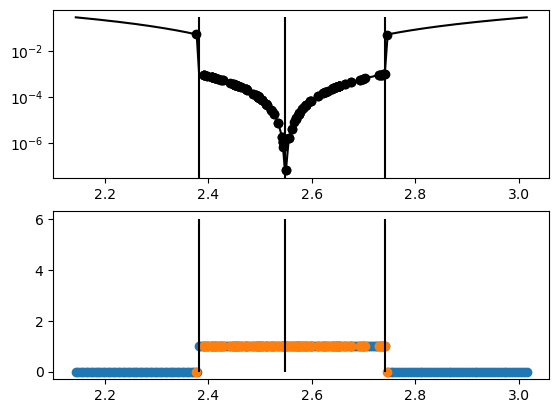

In [891]:
kargs ={"inside_weight": 0.2, "outside_weight":10, 
        "shift_weight":0.5, "Z_weight":0.1,
        "use_diffraction": True, "mode": "middle",
        "optimize_N": False, "optimize_location": True
}

res = cam.optimize_sharpness(target_points= target_points, **kargs)
graphics.plot_sharpness_optimisation(cam, target_points= target_points, res=res, **kargs)
viewer.update()

(np.float64(2.564828750336838), np.float64(0.10243620093172766))

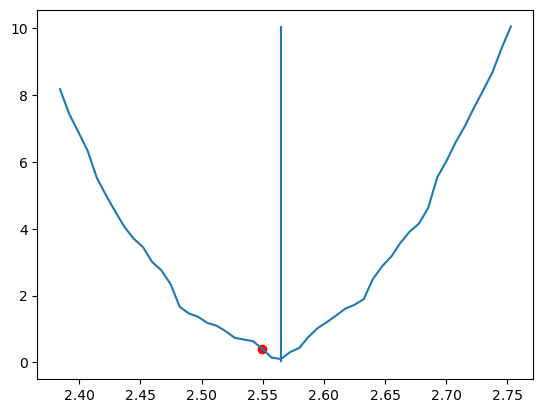

In [892]:
graphics.plot_sharpness_optimisation_cost(
    cam= cam, target_points= target_points, res= res, **kargs
)

## Dev optim

In [726]:
def get_limits(Z, optimize_N= True, use_diffraction= True):
    N = cam.compute_optimal_aperture(Z = Z) if optimize_N and use_diffraction else cam.N
    if use_diffraction:
        return cam._compute_sharpness_zone_including_diffraction(Z=Z, N=N)
    else:
        return cam._compute_sharpness_zone(Z, N if optimize_N else None)

def inner_zone(zx, Z1d, Z2d, mode= "middle"):
    if mode == "front":
        return zx >= Z1d
    elif mode == "back":
        return zx <= Z2d
    else:
        return np.logical_and(zx >= Z1d, zx <= Z2d)

def cost(zx, cam_shift, Z, optimize_N= True, mode = "middle", use_diffraction= True, w_in= 0.1, w_out=1):
    """_summary_

    Todo add a mode param: front back middle=default
    fix N or not
    
    :param zx: _description_
    :type zx: _type_
    :param cam_shift: _description_
    :type cam_shift: _type_
    :param Z: _description_
    :type Z: _type_
    :param w_in: _description_, defaults to 0.1
    :type w_in: float, optional
    :param w_out: _description_, defaults to 1
    :type w_out: int, optional
    :return: _description_
    :rtype: _type_
    """
    Z1d, Z2d = get_limits(Z, optimize_N= optimize_N, use_diffraction= use_diffraction)
    
    zx = zx + cam_shift
    zi = inner_zone(zx, Z1d, Z2d, mode)
    
    x = zx - Z
    scaled = np.where(x<0, x/Z1d, x/Z2d)
    w = np.where(zi, w_in, w_out)
        
    return np.multiply(w, scaled**2)

def plot_cost(target_zx, cam_shift, w_in= 0.1, w_out=1, n= 50):
    target_zx_init = target_zx
    target_zx = target_zx_init + cam_shift
    
    Z = np.linspace(target_zx.min(), target_zx.max(), n)
    total_cost = [np.sum(cost(target_zx_init, cam_shift, Z_i, w_in=w_in, w_out=w_out)) for Z_i in Z]
    plt.plot(Z, total_cost)
    
    global_min = np.argmin(total_cost)
    plt.vlines(Z[global_min], 0, max(total_cost))
    return Z[global_min], total_cost[global_min]
    
def plot_optim(target_zx, cam_shift, Z, optimize_N= True, mode = "middle", use_diffraction= True, w_in= 0.1, w_out=1):

    target_zx_init = target_zx
    target_zx = target_zx_init + cam_shift
    
    Z1d, Z2d = get_limits(Z, optimize_N= optimize_N, use_diffraction= use_diffraction)
    zx = np.concatenate((
        np.linspace(
            min(0.9*Z1d, target_zx.min()),
            Z1d, endpoint=False),
        np.linspace(
            Z1d, Z2d, 100, endpoint= False
        ),
        np.linspace(
            Z2d,
            max(1.1*Z2d, target_zx.max())
        )
    ))
    zi = inner_zone(zx, Z1d, Z2d, mode)
    target_zi = inner_zone(target_zx, Z1d, Z2d, mode)

    fig, ax = plt.subplots(2,1)
    ax[1].scatter( zx, zi)
    ax[1].scatter( target_zx, target_zi)

    ax[1].vlines([Z, Z1d, Z2d], 0, 6, "k")


    c = cost(zx - cam_shift, cam_shift, Z, w_in=w_in, w_out=w_out, optimize_N= optimize_N, use_diffraction= use_diffraction, mode= mode)
    ax[0].plot(zx, c, "k-")
    ax[0].scatter(target_zx, cost(target_zx_init, cam_shift, Z, w_in=w_in, w_out=w_out, optimize_N= optimize_N, use_diffraction= use_diffraction, mode= mode), c="k")

    ax[0].vlines([Z, Z1d, Z2d], 0, c.max(), "k")
    

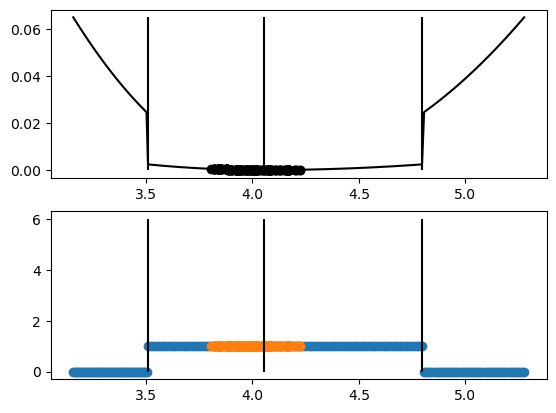

In [727]:

facing = obj.point_data["facing_b"]
target_points = obj.points[facing]
target_zx = cam._compute_camera_coordinates(target_points)[:,0]

Z = cam.Z

plot_optim(target_zx, cam_shift= -0.1, Z= Z,
           use_diffraction= False,
           mode= "default")

In [728]:
w_in, w_out = np.array([0.1, 10]) * 150 / len(target_zx)
w_shift = 0.1
res = optim.minimize(
    lambda x: np.sum(cost(target_zx, x[1], x[0], w_in= w_in, w_out= w_out,
                          mode= "front"
                          )) + w_shift * x[1]**2,
    x0= [target_zx.mean(), 0 ],
    #bounds= (target_zx.min(), target_zx.max()),
    method= "CG",
    options={'return_all':True}
)
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.010254408004042174
       x: [ 4.102e+00  2.557e-02]
     nit: 3
     jac: [-2.320e-07 -1.721e-07]
    nfev: 24
    njev: 8
 allvecs: [array([ 4.095e+00,  0.000e+00]), array([ 4.086e+00,  1.015e-02]), array([ 4.102e+00,  2.553e-02]), array([ 4.102e+00,  2.557e-02])]

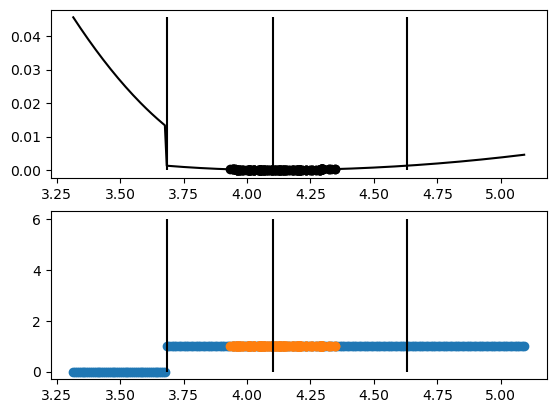

In [729]:
plot_optim(target_zx, res.x[1], res.x[0], mode= "front")

In [765]:

viewer.show()
viewer.plotter.add_mesh(target_points)
viewer.plotter.camera.position = [-0.5,-3,0.25]
viewer.plotter.camera.focal_point = [-0.5,0,0.25]
viewer.plotter.camera.up = [0,0,1]
viewer.plotter.parallel_projection = True

Widget(value='<iframe src="http://localhost:65028/index.html?ui=P_0x269433ed010_98&reconnect=auto" class="pyvi…

In [776]:
cam.update_aperture(4.4)
viewer.update()

In [758]:
loc = cam.location
N = cam.N
Z = cam.Z
loc, N, Z

(array([-2.59218633,  0.        ,  0.15670434]),
 4.4,
 np.float64(2.3144761586660194))

In [703]:
cam.location, cam.N, cam.Z

(array([-2.86033801,  0.        ,  0.15670434]),
 6.35,
 np.float64(2.5836281599702375))

In [813]:
cam.move_to(loc)
cam.update_focus(Z)
cam.update_aperture(N)
cam.location, cam.N, cam.Z

(array([-2.59218633,  0.        ,  0.15670434]),
 4.4,
 np.float64(2.3144761586660194))

In [663]:
cam.update_focus(Z)

In [780]:
cam.update_aperture()
viewer.update()

((np.float64(0.3), np.float64(7.141877794410544)), (np.float64(-1.8444596362620065), np.float64(4.628952317332039)))
Mode: middle:
shift: 0.272
Z: 2.59


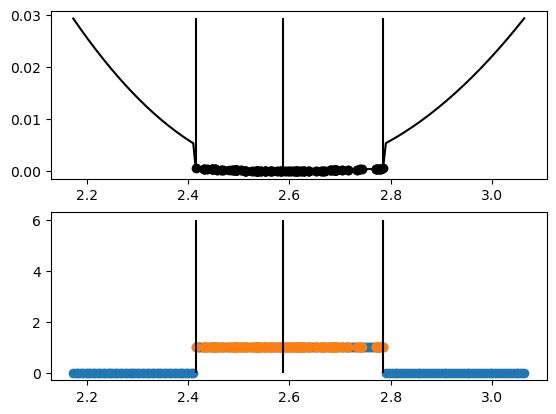

In [815]:
mode = "middle" # alternate front back or middle
use_diffraction = True
optim_location= True # only for middle

w_in, w_out = np.array([0.2, 10]) * 150 / len(target_zx)
w_shift = 0.1 #0.2
w_Z = 0.05
lim = 2 * cam.Z

optim_method = optim.differential_evolution #optim.shgo #


target_zx = cam._compute_camera_coordinates(target_points)[:,0]
min_zx, max_zx = target_zx.min(), target_zx.max()

bounds = (
    (cam.min_focus_distance, max_zx + lim),
    (-min_zx + cam.min_focus_distance, lim)
)
#[(cam.min_focus_distance, 2* cam.Z), 
                # (cam.min_focus_distance - Z, 2 * Z) ]
    
print(bounds)
if mode == "front":
    res = optim_method(
        lambda x: np.sum(
            cost(target_zx, 0, x[0], w_in= w_in, w_out= w_out,
                            mode= mode,
                            use_diffraction=use_diffraction
                            )) - w_Z * x[0]**2, ## minimize Z as well
        bounds= [(min_zx, max_zx )]
    )
    
elif mode == "back":
    res = optim_method(
        lambda x: np.sum(
            cost(target_zx, 0, x[0], w_in= w_in, w_out= w_out,
                            mode= mode,
                            use_diffraction=use_diffraction
                            )) + w_Z * x[0]**2, ## minimize Z as well
        bounds= [(min_zx, max_zx )]
    )
else:
    if optim_location:
        res = optim_method(
            lambda x: np.sum(
                cost(target_zx, x[1], x[0], w_in= w_in, w_out= w_out,
                                mode= mode,
                                use_diffraction=use_diffraction
                                )
                ) + w_shift * (min_zx + x[1])**2,
            bounds= bounds
        )
    else:
        res = optim_method(
            lambda x: np.sum(
                cost(target_zx, 0, x[0], w_in= w_in, w_out= w_out,
                                mode= mode,
                                use_diffraction=use_diffraction
                                )
                ) ,
            bounds= [(min_zx, max_zx )]
        )
    
cam_shift = res.x[1] if len(res.x)>1 else 0
print(f"Mode: {mode}:\nshift: {cam_shift:.3f}\nZ: {res.x[0]:.2f}" )
plot_optim(target_zx, cam_shift, res.x[0], mode= mode, use_diffraction= use_diffraction)


In [811]:
cam.move( cam_shift, "backward")
cam.update_focus(res.x[0], optimize_N= use_diffraction)
viewer.update()

Mode: middle:
shift: 0.413
Z: 2.58


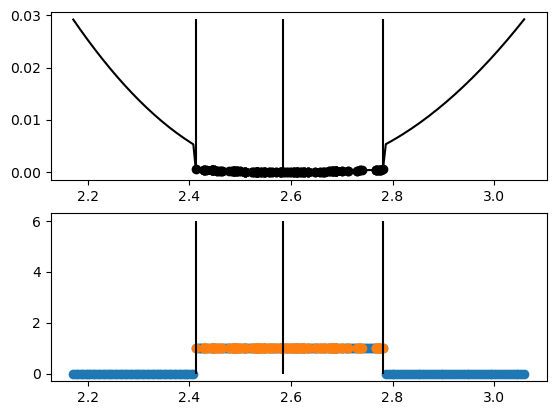

In [688]:
mode = "middle" # alternate front back or middle
w_in, w_out = np.array([0.1, 10]) * 150 / len(target_zx)
w_shift = 0.3 #0.2
lim = 1000 #0.5 * cam.Z

if mode == "front" or mode =="back":
    res = optim.shgo(
        lambda x: np.sum(
            cost(target_zx, 0, x[0], w_in= w_in, w_out= w_out,
                            mode= mode
                            )),
        bounds= [(target_zx.min(), target_zx.max() )]
    )
else:
    res = optim.differential_evolution(
        lambda x: np.sum(
            cost(target_zx, x[1], x[0], w_in= w_in, w_out= w_out,
                            mode= mode
                            )
            ) + w_shift * x[1]**2,
        bounds= [(cam.min_focus_distance, 2* cam.Z), 
                 (cam.min_focus_distance - Z, 5 * Z) ]
                #((target_zx.min() - lim, target_zx.max() + lim),
                #(-lim, lim))
    )
    
cam_shift = res.x[1] if len(res.x)>1 else 0
print(f"Mode: {mode}:\nshift: {cam_shift:.3f}\nZ: {res.x[0]:.2f}" )
plot_optim(target_zx, cam_shift, res.x[0], mode= mode)


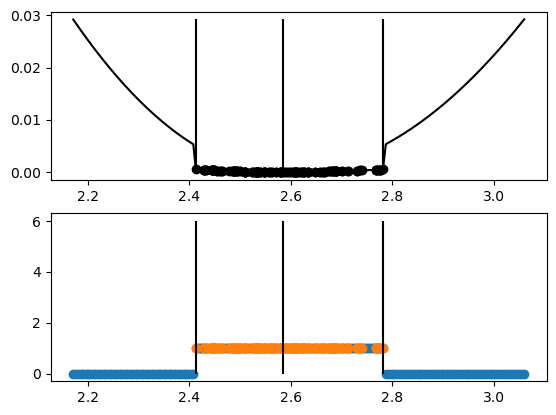

In [557]:
plot_optim(target_zx, res.x[1], res.x[0])

In [548]:
w_in, w_out = np.array([0.1, 10]) * 150 / len(target_zx)
w_shift = 0.1
lim = 1
res = optim.direct(
    lambda x: np.sum(cost(target_zx, x[1], x[0], w_in= w_in, w_out= w_out)) + w_shift * x[1]**2,
    #x0= [target_zx.mean(), 0 ],
    bounds= ((target_zx.min() - lim, target_zx.max() + lim),
             (-lim, lim))
)
res

 message: Number of function evaluations done is larger than maxfun=2000
 success: False
  status: 1
     fun: 0.04534588499964641
       x: [ 2.669e+00  5.062e-01]
     nit: 106
    nfev: 2011

(np.float64(2.585302527438496), np.float64(0.021331805791509253))

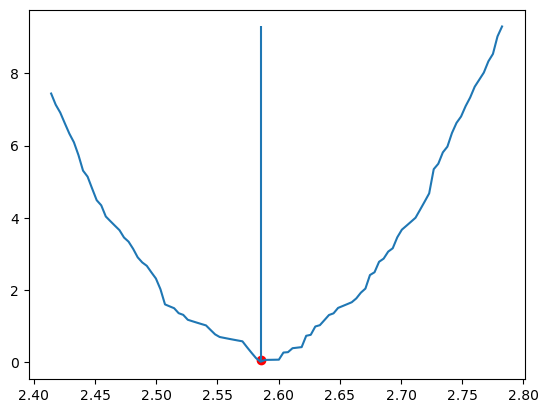

In [563]:

plt.scatter(res.x[0], res.fun, c= "r")
plot_cost(target_zx, cam_shift= res.x[1], w_in= w_in, w_out= w_out, n=100)

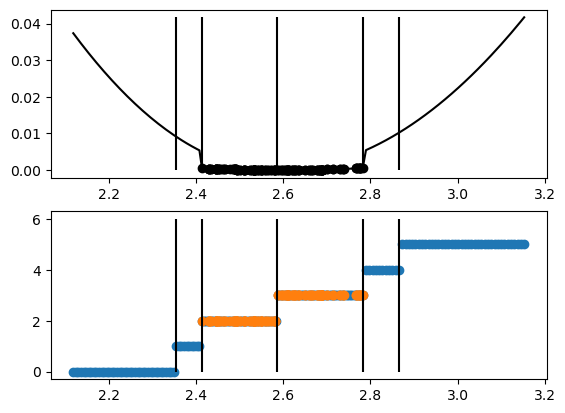

In [546]:
plot_optim(target_zx, res.x[1], res.x[0])

In [535]:
res.x

array([2.58246396, 0.41133317])

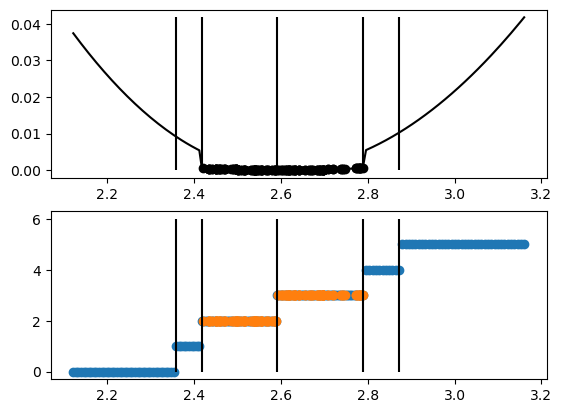

In [539]:
plot_optim(target_zx, 0.42, 2.59)

In [444]:
cam.optimize_focus_for_sharpness(obj.points)
viewer.update()

In [311]:
cam.optimize_focus_for_sharpness(obj.points, mode="back")
viewer.update()

In [312]:
cam.optimize_focus_for_sharpness(obj.points, mode="both")
viewer.update()

In [313]:
facing = obj.point_data["facing_b"]
target_points = obj.points[facing]
_ =viewer.plotter.add_mesh(target_points)

In [321]:
cam.optimize_focus_for_sharpness(
    obj.points[obj.point_data["facing_b"]],
    mode= "front",
    inside_weight= 0)
viewer.update()

In [316]:
cam.optimize_focus_for_sharpness(
    obj.points[obj.point_data["facing_b"]],
    mode= "back")
viewer.update()

In [317]:
cam.optimize_focus_for_sharpness(
    obj.points[obj.point_data["facing_b"]],
    mode= "both")
viewer.update()

In [209]:
cam.update_focus(Z= 1.2, optimize_N= True)
viewer.update()
cam.N

6.35

In [211]:
facing = obj.point_data["facing_b"]
target_points = obj.points[facing]
cam_coords = cam._compute_camera_coordinates(target_points)
zx = cam_coords[:,0]

In [285]:
Z = 1.5
inside_weight = 100
print("Z:",Z)
N = cam.compute_optimal_aperture(Z = Z)
print("N:",N)
Z1d, Z2d = cam._compute_sharpness_zone_including_diffraction(Z=Z, N=N)
print("Z1d Z2d:", Z1d,", ",Z2d)
front_points = zx < Z1d
front_cost = np.sum((Z1d - zx[front_points])**2)
back_points = zx > Z2d
back_cost = np.sum((Z2d - zx[back_points])**2)
cost = front_cost + back_cost
inside_front = np.logical_and(zx >= Z1d, zx<Z)
inside_front_cost = inside_weight * np.sum(((Z - zx[inside_front])/Z1d)**2)
inside_back = np.logical_and(zx <= Z2d, zx>Z)
inside_back_cost = inside_weight * np.sum(((Z - zx[inside_back])/Z2d)**2)
inside_cost = inside_front_cost + inside_back_cost

print("Cost {}: front ({}), back ({})".format(cost, front_cost, back_cost))
print("inside cost {}: front ({}), back ({})".format(inside_cost, inside_front_cost, inside_back_cost))

Z: 1.5
N: 6.35
Z1d Z2d: 1.4417694432666124 ,  1.563249935118598
Cost 3.3083448037767247: front (3.3083448037767247), back (0.0)
inside cost 0.0: front (0.0), back (0.0)


In [260]:
zx[inside_front]

array([1.16733158, 1.16733158, 1.1899142 ])

In [265]:
zx >Z

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [289]:
def cost_optim_Z_for_sharpness(Z):
    facing = cam.target_object.point_data["facing_b"]
    target_points = cam.target_object.points[facing]
    cam_coords = cam._compute_camera_coordinates(target_points)
    zx = cam_coords[:,0]
    N = cam.compute_optimal_aperture(Z = Z)
    Z1d, Z2d = cam._compute_sharpness_zone_including_diffraction(Z=Z, N=N)
    front_points = zx < Z1d
    front_cost = np.sum(((Z1d - zx[front_points])/Z1d)**2)
    back_points = zx > Z2d
    back_cost = np.sum(((Z2d - zx[back_points])/Z2d)**2)
    cost = front_cost + back_cost
    inside_front = np.logical_and(zx >= Z1d, zx<Z)
    inside_front_cost = inside_weight * np.sum(((Z - zx[inside_front])/Z1d)**2)
    inside_back = np.logical_and(zx <= Z2d, zx>Z)
    inside_back_cost = inside_weight * np.sum(((Z - zx[inside_back])/Z2d)**2)
    inside_cost = inside_front_cost + inside_back_cost
    return cost + inside_cost

In [291]:
inside_weight = 0.1
optim_Z = optim.minimize_scalar(cost_optim_Z_for_sharpness, bounds=(zx.min(), zx.max()))
print((optim_Z))

 message: Solution found.
 success: True
  status: 0
     fun: 16.4418572697492
       x: 1.2764179789914716
     nit: 23
    nfev: 23


In [216]:
cam.update_focus(Z= optim_Z.x, optimize_N= True)
viewer.update()
cam.N

6.35

Cost 35.317883030016326: front (35.317883030016326), back (0.0)


In [126]:
cam.get_aperture_number_list(step=1/3, rounding=2)

[1.0,
 1.12,
 1.26,
 1.41,
 1.59,
 1.78,
 2.0,
 2.24,
 2.52,
 2.83,
 3.17,
 3.56,
 4.0,
 4.49,
 5.04,
 5.66,
 6.35,
 7.13,
 8.0,
 8.98,
 10.08,
 11.31,
 12.7,
 14.25,
 16.0,
 17.96,
 20.16,
 22.63]

In [ ]:
cam.get_aperture_number_list(step=1/3, rounding= 2)

[1.0,
 1.12,
 1.26,
 1.41,
 1.59,
 1.78,
 2.0,
 2.24,
 2.52,
 2.83,
 3.17,
 3.56,
 4.0,
 4.49,
 5.04,
 5.66,
 6.35,
 7.13,
 8.0,
 8.98,
 10.08,
 11.31,
 12.7,
 14.25,
 16.0,
 17.96,
 20.16,
 22.63]

In [99]:
max_N = 32+0.1
n_max = np.log(max_N)/np.log(np.sqrt(2))+1
[round(float(np.sqrt(2)**(i-1)),2) for i in np.arange(1, n_max, 1/3)]

[1.0,
 1.12,
 1.26,
 1.41,
 1.59,
 1.78,
 2.0,
 2.24,
 2.52,
 2.83,
 3.17,
 3.56,
 4.0,
 4.49,
 5.04,
 5.66,
 6.35,
 7.13,
 8.0,
 8.98,
 10.08,
 11.31,
 12.7,
 14.25,
 16.0,
 17.96,
 20.16,
 22.63,
 25.4,
 28.51,
 32.0]

In [90]:
2**n_max

np.float64(24.999999999999993)

In [66]:
sum_sqr_dt = lambda N: lambda zx: np.sum(cam._compute_combined_blur_spot_diameter(zx, N=N)**2)


In [75]:
cam._compute_depth_of_field_with_diffraction(N=2.8)

np.float64(0.031186658165539893)

In [47]:
cam.update_aperture(22)
zx = np.linspace(cam.Z1, cam.Z2)

8980.128185199526


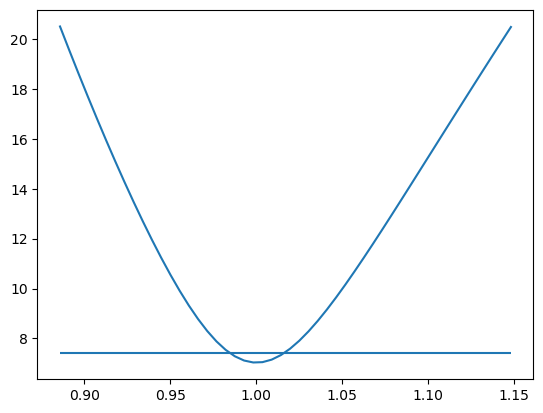

In [58]:
N_i = 8.5
cost = optim_function(N_i)(zx)
print(cost)
plt.plot(zx, cam._compute_combined_blur_spot_diameter(zx, N=N_i))
plt.hlines(cam.confusion_circle_diameter*1000, zx.min(), zx.max())

240015.1793703037
60255.15040674295
16581.544352207227
9537.086431338017


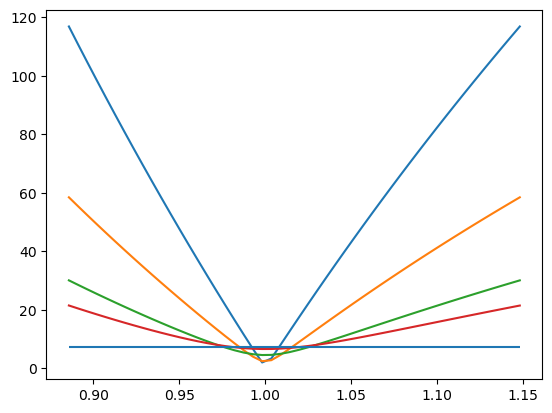

In [61]:
for N_i in [1.4, 2.8, 5.5, 8]:#cam.get_aperture_number_list():
    cost = optim_function(N_i)(zx)
    print(cost)
    plt.plot(zx, cam._compute_combined_blur_spot_diameter(zx, N=N_i))
plt.hlines(cam.confusion_circle_diameter*1000, zx.min(), zx.max())

In [78]:
optim.minimize_scalar(lambda N: -cam._compute_depth_of_field_with_diffraction(N=N), bounds=(cam.get_aperture_number_list()[0], cam._compute_maximum_sharp_aperture())).x

np.float64(7.8241583001159265)

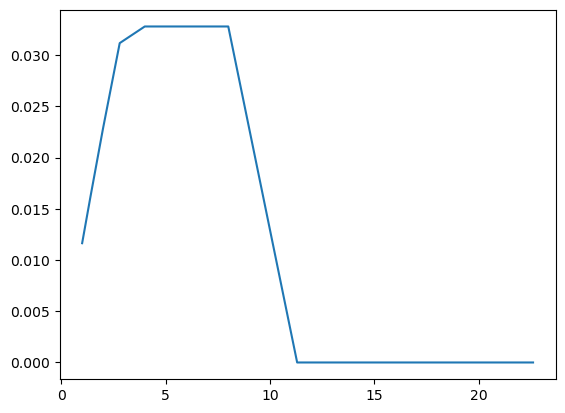

In [76]:
N_list = cam.get_aperture_number_list()
costs = [cam._compute_depth_of_field_with_diffraction(N=N_i) for N_i in N_list]
plt.plot(N_list, costs)

In [ ]:
# take points
# compute z
# compute dt
# minimize sum(dt²)

# testing pyvista

In [1]:
import pyvista as pv
import numpy as np

In [98]:
# Get system info
print(pv.Report())


--------------------------------------------------------------------------------
  Date: Fri Jun 20 11:30:46 2025 Paris, Madrid (heure d’été)

                OS : Windows (10 10.0.19045 SP0 Multiprocessor Free)
            CPU(s) : 8
           Machine : AMD64
      Architecture : 64bit
               RAM : 15.9 GiB
       Environment : Jupyter
        GPU Vendor : Intel
      GPU Renderer : Intel(R) UHD Graphics 620
       GPU Version : 4.5.0 - Build 30.0.101.1338
  MathText Support : False

  Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:27:10) [MSC
  v.1938 64 bit (AMD64)]

           pyvista : 0.44.0
               vtk : 9.3.1
             numpy : 2.0.0
        matplotlib : 3.9.1
            scooby : 0.10.0
             pooch : 1.8.2
            pillow : 10.4.0
           IPython : 8.26.0
          colorcet : 3.1.0
        ipywidgets : 8.1.3
             scipy : 1.14.0
            meshio : 5.3.5
        jupyterlab : 4.2.3
             trame : 3.6.3
      trame_

In [ ]:
# create object and plotter
obj = pv.Sphere()
plotter = pv.Plotter()
actor = plotter.add_mesh(obj)
plotter.show()

# create a scalar array
# It is intentionnal to create it this way to avoid showing it at this stage
scalar_name = "test"
obj.point_data.set_array(np.random.rand(obj.n_points), scalar_name)

# something else would happen in the code including user interaction
# until then, if I show the scalar field, everything is as expected

# create and add a new object
obj2 = pv.Rectangle()
obj2.translate((1,0,0))
actor2 = plotter.add_mesh(obj2)

# After adding a new object, when I activate the scalar field,
# the colorbar is the on of the added object and not the selected one (ie., obj)
scalar_values = obj.point_data[scalar_name] 
vmin = np.min(scalar_values)
vmax = np.max(scalar_values)
cmap = "viridis"
obj.set_active_scalars(scalar_name)
mapper = actor.mapper
mapper.scalar_visibility = True
mapper.array_name = scalar_name
mapper.scalar_range = vmin, vmax
mapper.lookup_table.cmap = cmap

plotter.add_scalar_bar(scalar_name, 
                actor.mapper,  # <- here, giving the mapper this way just ignores it
                # mapper= actor.mapper,   # <- this fixes the problem
                interactive= True
                )

Widget(value='<iframe src="http://localhost:63049/index.html?ui=P_0x1e688375a90_15&reconnect=auto" class="pyvi…

<vtkmodules.vtkRenderingAnnotation.vtkScalarBarActor(0x000001E6944C7720) at 0x000001E6883AF5E0>

In [70]:
obj2 = pv.Rectangle()
obj2.translate((1,0,0))
actor2 = plotter.add_mesh(obj2)

In [75]:
scalar_name = "test2"
obj.point_data[scalar_name] = np.random.rand(obj.n_points)

In [76]:
vmin, vmax = 0,1
scalar_values = obj.point_data[scalar_name] 
vmin = min(vmin, np.min(scalar_values))
vmax = max(vmax, np.max(scalar_values))

In [77]:
cmap = "viridis"
obj.set_active_scalars(scalar_name)
mapper = actor.mapper
mapper.scalar_visibility = True
mapper.array_name = scalar_name
mapper.scalar_range = vmin, vmax
mapper.lookup_table.cmap = cmap


In [79]:
plotter.update()

In [86]:

for key in list(plotter.scalar_bars.keys()):
    plotter.remove_scalar_bar(key)

In [87]:
plotter.add_scalar_bar(scalar_name, 
                actor.mapper,
                interactive= True,
                vertical= True
                )

<vtkmodules.vtkRenderingAnnotation.vtkScalarBarActor(0x000001E6944C5DB0) at 0x000001E6C17FBA60>

In [88]:
plotter.scalar_bars.keys()

dict_keys(['test2'])

In [95]:
print(plotter.scalar_bar)

vtkScalarBarActor (000001E6944C5DB0)
  Debug: Off
  Modified Time: 542666
  Reference Count: 3
  Registered Events: (none)
  Dragable: On
  Pickable: Off
  AllocatedRenderTime: 3.96977
  EstimatedRenderTime: 0
  NumberOfConsumers: 1
  RenderTimeMultiplier: 0.001
  Visibility: On
  PropertyKeys: none.
  useBounds: 1
  Layer Number: 0
  PositionCoordinate: 000001E6DAE270E0
    Debug: Off
    Modified Time: 542104
    Reference Count: 17
    Registered Events: (none)
    Coordinate System: Normalized Viewport
    Value: (0.82,0.1,0)
    ReferenceCoordinate: (none)
    Viewport: (none)
  Position2 Coordinate: 000001E6DAE28DE0
    Debug: Off
    Modified Time: 542105
    Reference Count: 1
    Registered Events: (none)
    Coordinate System: Normalized Viewport
    Value: (0.17,0.8,0)
    ReferenceCoordinate: 000001E6DAE270E0
    Viewport: (none)
  Property: 000001E6EC402E20
    Debug: Off
    Modified Time: 542665
    Reference Count: 7
    Registered Events: (none)
    Opacity: 1
    Colo

In [82]:
actor.mapper

DataSetMapper (0x1e6dae91f60)
  Scalar visibility:           True
  Scalar range:                (0.0, 1.0)
  Interpolate before mapping:  True
  Scalar map mode:             point
  Color mode:                  map

Attached dataset:
PolyData (0x1e6dae912a0)
  N Cells:    1680
  N Points:   842
  N Strips:   0
  X Bounds:   -4.993e-01, 4.993e-01
  Y Bounds:   -4.965e-01, 4.965e-01
  Z Bounds:   -5.000e-01, 5.000e-01
  N Arrays:   3

In [83]:
obj

PolyData (0x1e6dae912a0)
  N Cells:    1680
  N Points:   842
  N Strips:   0
  X Bounds:   -4.993e-01, 4.993e-01
  Y Bounds:   -4.965e-01, 4.965e-01
  Z Bounds:   -5.000e-01, 5.000e-01
  N Arrays:   3

In [62]:
plotter.update_scalar_bar_range((vmin,vmax),scalar_name)

In [59]:
obj2 = pv.Rectangle()
obj2.translate((1,0,0))
actor2 = plotter.add_mesh(obj2)

In [45]:
plotter.update()

In [ ]:
plotter.update()

# overlap shots

In [105]:
obj, cam, viewer = graphics.get_default_scene()

Widget(value='<iframe src="http://localhost:63049/index.html?ui=P_0x1e726457c10_17&reconnect=auto" class="pyvi…

In [106]:
viewer.set_active_scalars("nb_views")

In [107]:
cam.trigger()

In [169]:
nb_views  = cam.views[obj].sum(axis=0)

<BarContainer object of 98 artists>

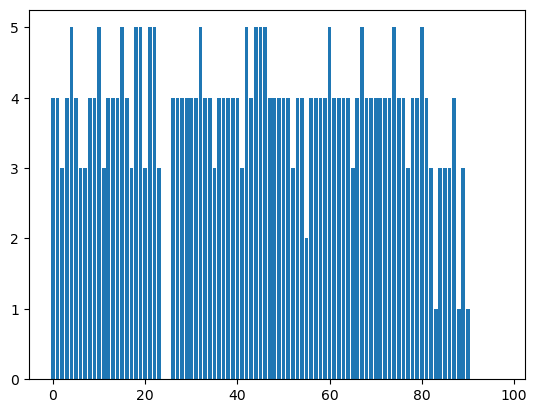

In [175]:
plt.bar(range(len(nb_views)), nb_views)

In [176]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
sns.range(len(nb_views)), nb_views)

<BarContainer object of 98 artists>

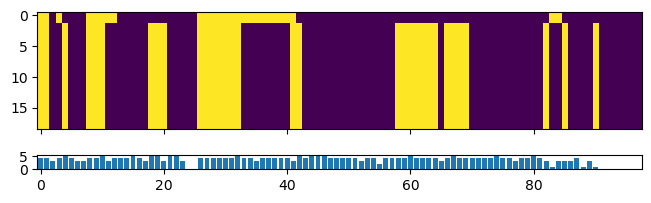

In [205]:
fig, ax = plt.subplots(2, 1, sharex= True, 
                       layout="compressed",
                       gridspec_kw= dict(height_ratios=[1, 0.1]))
ax[0].imshow(views)
ax[1].bar(range(len(nb_views)), nb_views)

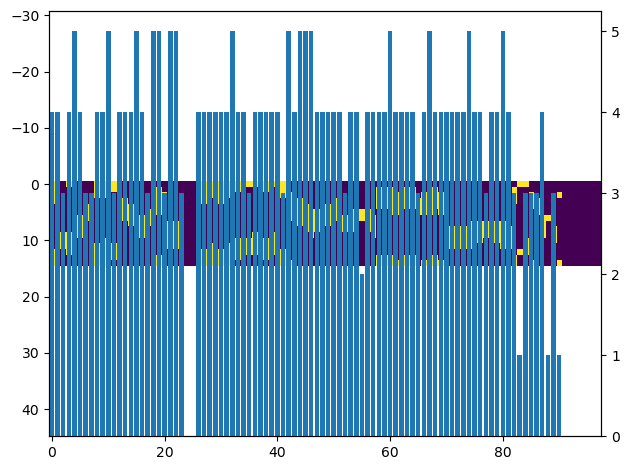

In [180]:
cam.orbit(30, obj.center)
cam.trigger()
graphics.plot_view_matrix(cam)
viewer.update()

ax = plt.twinx()
ax.bar(range(len(nb_views)), nb_views)
plt.gcf().set_tight_layout(tight=True)

In [ ]:
cam.views[obj]

In [ ]:
plt.barplot()

In [90]:
viewer.update()

In [112]:
views = np.empty((0, obj.n_points), dtype= bool)

In [200]:
views = np.concatenate((views, [obj.point_data["visible_b"]]))

In [115]:
views

array([[ True,  True, False,  True, False, False, False, False,  True,
         True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False]])

In [117]:
views[:,0]

array([ True,  True])

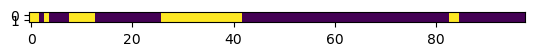

In [120]:

plt.imshow(views)

In [89]:
obj.point_data.update(
    dict(nb_views=
         np.where(
            obj.point_data["visible_b"],
            obj.point_data["nb_views"]+1,
            obj.point_data["nb_views"]
         )
    )
)

In [63]:
obj.point_data[obj.point_data["visible_b"]]

TypeError: Only strings are valid keys for DataSetAttributes.

In [50]:
obj.point_data.keys()

['TCoords',
 'Normals',
 'x',
 'y',
 'z',
 'angle_width',
 'angle_height',
 'pix_i',
 'pix_j',
 'facing_b',
 'in_view_b',
 'visible_b',
 'facing',
 'in_view',
 'visible',
 'resolution',
 'nb_views']

In [49]:
obj.point_data.set_array(0., "nb_views")

In [52]:
obj.point_data["nb_views"] += 1

# Testing scene import from metashape

In [1]:
import pyvista as pv
import os

In [2]:
dir = r"C:\Users\glaurent\Documents\Recherche\Projets\001_Photogrammetrie\travaux\008_TERD_Samples\001_NK_104_Scheelite\export"

In [3]:
filename = "sheelite_tie_points.obj"
path = os.path.join(dir,filename)
print(path)

C:\Users\glaurent\Documents\Recherche\Projets\001_Photogrammetrie\travaux\008_TERD_Samples\001_NK_104_Scheelite\export\sheelite_tie_points.obj


In [4]:
tie = pv.read(path)

In [5]:
tie

PolyData (0x2686894fa00)
  N Cells:    62959
  N Points:   62959
  N Strips:   0
  X Bounds:   -8.534e-01, 1.343e+00
  Y Bounds:   -1.292e-01, 2.014e-01
  Z Bounds:   -6.352e+00, -4.197e+00
  N Arrays:   1

In [ ]:
tie.plot(eye_dome_lighting= True)

Widget(value='<iframe src="http://localhost:65028/index.html?ui=P_0x26868977510_0&reconnect=auto" class="pyvis…

ERROR:wslink.protocol:Exception raised
ERROR:wslink.protocol:KeyError('837e2a1a7846fa4a6d666c69eb8d1370_12d')
ERROR:wslink.protocol:Traceback (most recent call last):
  File "c:\Users\glaurent\Documents\Outils\Anaconda\envs\pypho\Lib\site-packages\wslink\protocol.py", line 309, in onCompleteMessage
    results = func(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\glaurent\Documents\Outils\Anaconda\envs\pypho\Lib\site-packages\trame_vtk\modules\vtk\protocols\local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "c:\Users\glaurent\Documents\Outils\Anaconda\envs\pypho\Lib\site-packages\trame_vtk\modules\vtk\serializers\synchronization_context.py", line 35, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
                ~~~~~~~~~~~~~~~~~~~~~^^^^^^^
KeyError: '837e2a1a7846fa4a6d666c69eb8d1370_12d'

ERROR:wslink.protocol:Exception raised
ERROR:wslink.protocol:KeyError('0065893610c4b3366a7046e05

In [42]:
importlib.reload(graphics)

<module 'pypho.design.graphics' from 'c:\\Users\\glaurent\\Documents\\Dev\\Projects\\PhotogrammetryTools\\notebooks\\01_photogrammetric_design\\../..\\pypho\\design\\graphics.py'>

In [46]:
import numpy as np
# Seed the random number generator for generating data
rng = np.random.default_rng(seed=0)


# Define some helpers - ignore these and use your own data.
def generate_points(subset=0.02):
    """Make a 3D NumPy array of points (n_points by 3)."""
    dataset = pv.examples.download_lidar()
    ids = rng.integers(
        low=0,
        high=dataset.n_points - 1,
        size=int(dataset.n_points * subset),
    )
    return dataset.points[ids]


points = generate_points()
point_cloud = pv.PolyData(points)

In [47]:
test_target = target.TargetObject(point_cloud)
viewer = graphics.Viewer3D(objects= test_target)
viewer.show()

plot points
TargetObject (0x24d84b22e60)
  N Cells:    0
  N Points:   67841
  N Strips:   0
  X Bounds:   4.809e+05, 4.811e+05
  Y Bounds:   4.400e+06, 4.400e+06
  Z Bounds:   1.754e+03, 1.787e+03
  N Arrays:   0


Widget(value='<iframe src="http://localhost:64708/index.html?ui=P_0x24d84b3d950_46&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:64708/index.html?ui=P_0x24d84ba2650_45&reconnect=auto" class="pyvi…

In [ ]:
tie_target = target.TargetObject(tie)
viewer = graphics.Viewer3D(objects= tie_target)
viewer.show()

plot points
TargetObject (0x24d79807640)
  N Cells:    0
  N Points:   62959
  N Strips:   0
  X Bounds:   -8.534e-01, 1.343e+00
  Y Bounds:   -1.292e-01, 2.014e-01
  Z Bounds:   -6.352e+00, -4.197e+00
  N Arrays:   1


Widget(value='<iframe src="http://localhost:64708/index.html?ui=P_0x24d515b8290_40&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:64708/index.html?ui=P_0x24d51544690_39&reconnect=auto" class="pyvi…

In [14]:
plotter = pv.Plotter()
texture = viewer.object_texture[tie_target] if tie_target in viewer.object_texture else viewer.target_param["target_object_texture"] 
        
plotter.add_mesh(tie,
            split_sharp_edges= True,
            line_width= viewer.target_param["target_object_line_width"],
            backface_params=dict(
                color= viewer.target_param["target_object_backface_color"],
                opacity= viewer.target_param["target_object_backface_opacity"]
                ),
            opacity= viewer.target_param["target_object_opacity"],
            scalars= viewer.target_param["target_object_scalar"],
            scalar_bar_args= viewer.target_param["scalar_bar_args"]
                 )
plotter.show()

Widget(value='<iframe src="http://localhost:64708/index.html?ui=P_0x24d11452450_6&reconnect=auto" class="pyvis…

In [9]:
scheelite = target.TargetObject(pv.read(os.path.join(dir, "sheelite_low.obj")))
scheelite.plot()

Widget(value='<iframe src="http://localhost:65028/index.html?ui=P_0x268736aeed0_1&reconnect=auto" class="pyvis…

In [10]:
texture = pv.read_texture(os.path.join(dir,"sheelite_low.jpg"))

In [11]:
texture

Texture (0x268630b2500)
  Components:   3
  Cube Map:     False
  Dimensions:   4096, 4096

In [12]:
viewer = graphics.Viewer3D(objects= scheelite, target_object_texture= texture)
viewer.show()

Widget(value='<iframe src="http://localhost:65028/index.html?ui=P_0x26873e434d0_3&reconnect=auto" class="pyvis…

In [52]:
viewer.set_active_scalars("sheelite_low",scheelite)

In [55]:
viewer.remove_scalars()

## Testing diffraction in sharpness zone

In [3]:
import matplotlib.pyplot as plt

In [4]:
# in theory the sharp zone geos from Z1 to Z2
cam = camera.get_default_camera()


In [5]:
cam.depth_of_field

np.float64(0.0027030548585659786)

In [6]:
cam.depth_of_image

np.float64(0.04715096008884563)

In [7]:
z1_mm = cam.Z1 * 1000
z2_mm = cam.Z2 * 1000
depth_of_image = (z2_mm - z1_mm) * cam.focal**2 / (z2_mm - cam.focal) / (z1_mm - cam.focal) 
depth_of_image # in mm after Conrad 2006

np.float64(0.04715096008884563)

In [8]:
def compute_depth_of_image(cam):
    """Computes the image spread in millimeters"""
    z1_mm = cam.Z1 * 1000
    z2_mm = cam.Z2 * 1000
    return (z2_mm - z1_mm) * cam.focal**2 / (z2_mm - cam.focal) / (z1_mm - cam.focal) 
compute_depth_of_image(cam)

np.float64(0.04715096008884563)

In [9]:
cam._compute_depth_of_image()

np.float64(47.15096008884563)

In [10]:
z_mm = cam.Z1 * 1000 
defocus_diameter = depth_of_image / (2 * cam.N * (1 + cam.focal / z_mm))
defocus_diameter # in mm after Conrad 2006

np.float64(0.007536584953556183)

In [11]:
# our calculation
zx_mm = cam.Z1 * 1000 
z_mm = cam.Z * 1000
defocus_diameter = cam.focal**2 / cam.N * abs( z_mm - zx_mm) / zx_mm / (z_mm - cam.focal)
defocus_diameter # in mm

np.float64(0.007437500000000324)

In [12]:
def compute_defocus_diameter(cam, zx):
    """Computes the diameter of the image disk due to defocus

    :param zx: the distance of the object in meters
    :type zx: float
    :returns: the defocus diameter in millimeters
    """
    zx_mm = zx * 1000 
    z_mm = cam.Z * 1000
    defocus_diameter = cam.focal**2 / cam.N * abs( z_mm - zx_mm) / zx_mm / (z_mm - cam.focal)
    return defocus_diameter
compute_defocus_diameter(cam, cam.Z2)

np.float64(0.007437499999999856)

In [13]:
cam._compute_defocus_diameter(cam.Z2)

np.float64(7.437499999999856)

In [14]:
def compute_defocus_diameter_conrad(cam, z):
    z_mm = z * 1000
    depth_of_image = compute_depth_of_image(cam)
    return depth_of_image / (2 * cam.N * (1 + cam.focal / z_mm))
compute_defocus_diameter_conrad(cam, cam.Z1), compute_defocus_diameter_conrad(cam, cam.Z2)

(np.float64(0.007536584953556183), np.float64(0.007543682807942136))

In [15]:
cam.confusion_circle_diameter

np.float64(0.0074375000000000005)

In [16]:
def compute_diffraction_diameter(cam, zx, wavelength_nm= 546, effective_part= 1):
    """Computes the Airay diameter of diffraction partern
    
    :param zx: the distance of the object in meters
    :type zx: float
    :param wavelength_nm: the wavelength of the light in nanometers (default to 546 nm, yellow-green light)
    :type float:
    :returns: the diameter of the first black circle in the diffraction patern in mm
    """
    zx_mm = zx * 1000
    lambda_mm = wavelength_nm / 1e6
    return 2.44 * lambda_mm * cam.N * (1 + cam.focal / zx_mm) * effective_part
compute_diffraction_diameter(cam, cam.Z)

np.float64(0.0041654704)

In [17]:
def compute_combined_diameter(cam, zx, wavelength_nm= 546, effective_part= 1):
    defocus_diameter = compute_defocus_diameter(cam, zx)
    diffraction_diameter = compute_diffraction_diameter(cam, zx, wavelength_nm, effective_part= effective_part)
    return np.sqrt(defocus_diameter**2 + diffraction_diameter**2)

In [18]:
compute_combined_diameter(cam, cam.Z,effective_part= 0.6)*1000

np.float64(2.4992822400000003)

In [19]:
cam._compute_combined_blur_spot_diameter(cam.Z)

np.float64(2.49928224)

In [20]:
def compute_maximum_sharp_aperture(cam, wavelength= 546, effective_part= 1):
    lambda_mm = wavelength / 1e6
    z_mm = cam.Z * 1000
    return cam.confusion_circle_diameter / 2.44 / lambda_mm / (1 + cam.focal/z_mm) / effective_part
compute_maximum_sharp_aperture(cam, effective_part=0.6)

np.float64(8.33239226314832)

In [21]:
compute_maximum_sharp_aperture(cam, effective_part=0.6)

np.float64(8.33239226314832)

In [22]:
camera.get_default_camera()._compute_maximum_sharp_aperture()

np.float64(8.33239226314832)

In [23]:
importlib.reload(camera)

<module 'pypho.design.camera' from 'c:\\Users\\glaurent\\Documents\\Dev\\Projects\\PhotogrammetryTools\\notebooks\\01_photogrammetric_design\\../..\\pypho\\design\\camera.py'>

In [24]:
import scipy.optimize as optim


def compute_sharpness_zone_including_diffraction(cam, wavelength= 546, effective_part= 0.6):
    max_N = compute_maximum_sharp_aperture(cam, wavelength, effective_part)
    if cam.N >= max_N:
        return None, None
    optim_function = lambda zx: (cam.confusion_circle_diameter-compute_combined_diameter(cam, zx, wavelength, effective_part))**2
    z1_combined = optim.minimize_scalar(optim_function, bounds= (cam.Z1, cam.Z)).x
    z2_combined = optim.minimize_scalar(optim_function, bounds= (cam.Z, cam.Z2 if cam.Z2<np.inf else 1e6)).x
    return z1_combined, z2_combined

def compute_depth_of_field_with_diffraction(cam, wavelength= 546, effective_part= 0.6):
    z1, z2 = compute_sharpness_zone_including_diffraction(cam, wavelength, effective_part)
    return z2 - z1 if z1 is not None else 0


In [25]:
cam.confusion_circle_diameter

np.float64(0.0074375000000000005)

In [26]:
cam._compute_combined_blur_spot_diameter(cam.Z)

np.float64(2.49928224)

In [27]:
compute_sharpness_zone_including_diffraction(cam)

(np.float64(0.2987311158768661), np.float64(0.3012796974856151))

In [28]:
z1d, z2d = cam._compute_sharpness_zone_including_diffraction()
z1d, z2d

(np.float64(0.2987311158768661), np.float64(0.3012796974856151))

In [29]:
z2d - z1d

np.float64(0.00254858160874899)

In [30]:
compute_depth_of_field_with_diffraction(cam)

np.float64(0.00254858160874899)

In [31]:
cam._compute_depth_of_field_with_diffraction()

np.float64(0.00254858160874899)

In [32]:
def plot_depth_of_field_vs_aperture(cam, N= camera.Camera.get_aperture_number_list(9), wavelength= 546, effective_part=0.5, ax= None):
    
    ax = ax if ax is not None else plt.gca()
    dof = []
    for N_i in N:
        cam.update_aperture(N_i)
        dof_i = compute_depth_of_field_with_diffraction(cam, wavelength= wavelength, effective_part= effective_part)
        dof += [dof_i]
        
    ax.scatter(N,dof, c="k")

    dx, dy = 0.8, max(dof)/70
    for i, N_i in enumerate(N):
        ax.annotate(f"{N_i:.0f}" if N_i%1==0 else f"{N_i:.1f}", (N_i, dof[i]),
                    xytext= (N_i - (0.5 if N_i%1==0 else 1)*dx \
                        + (1 if i>0 and dof[i]<dof[i-1] else 0),
                        dof[i] + dy))

    N= np.linspace(1,N[-1], 200)
    cam.update_focus(Z= Z)
    dof = []
    for N_i in N:
        cam.update_aperture(N_i)
        dof += [compute_depth_of_field_with_diffraction(cam, wavelength= wavelength, effective_part= effective_part)]

    ax.plot(N,dof, "k")
    
    
    ax.set_title("Depth of field wrt. Aperture")
    ax.set_xlabel("N")
    ax.set_ylabel("Depth of field (m)")


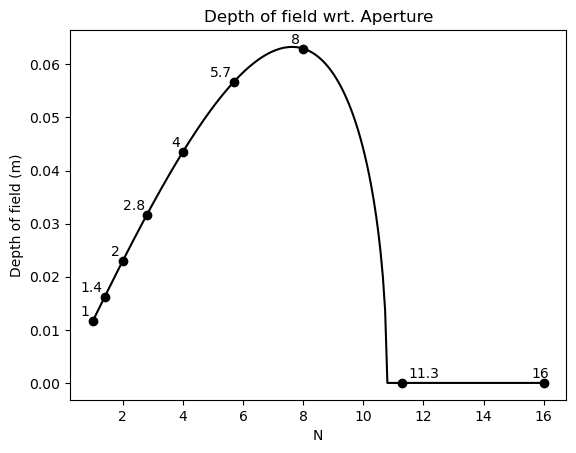

In [33]:
Z= 1
N= camera.Camera.get_aperture_number_list(9)
cam.update_focus(Z= Z)
plot_depth_of_field_vs_aperture(cam)

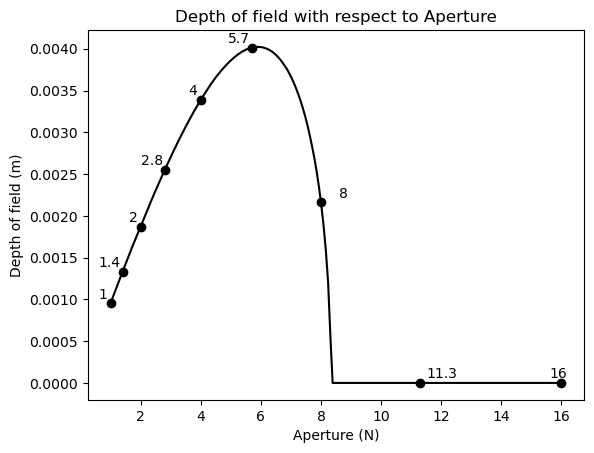

In [34]:
importlib.reload(camera)
importlib.reload(graphics)

graphics.plot_depth_of_field_vs_aperture(camera.get_default_camera())

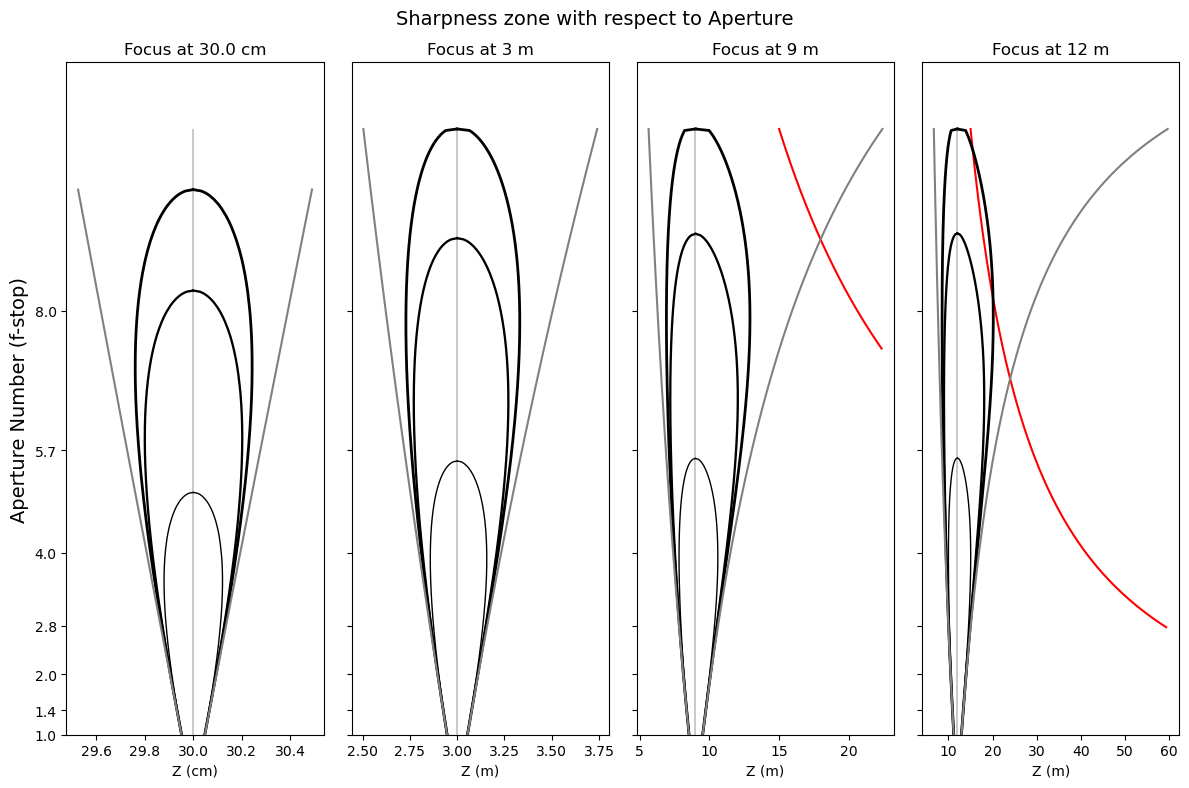

In [35]:
importlib.reload(graphics)
graphics.plot_sharpness_zone_vs_aperture(camera.get_default_camera(),
                                         Z_list=[0.3, 3, 9, 12])

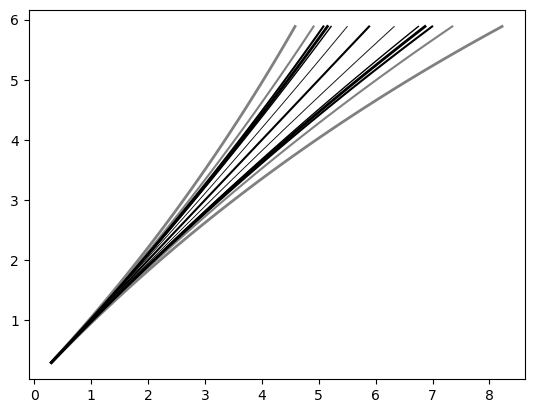

In [117]:
cam = camera.get_default_camera()
zmin=0.3
zmax= cam.H /10
z = np.linspace(zmin, zmax)

plt.plot(z,z,"k-")

for i, N_i in enumerate([2,  4, 5.6, 8]):
    cam.update_aperture(N_i)
    z1 , z2, z1_t, z2_t = [],[],[],[]
    for z_i in z:
        cam.update_focus(z_i)
        z1 += [cam.Z1]
        z2 += [cam.Z2]
        z1_t_i, z2_t_i = compute_sharpness_zone_including_diffraction(cam, wavelength= 546, effective_part= 0.6)
        z1_t += [z1_t_i]
        z2_t += [z2_t_i]
    plt.plot(z1, z, color="gray", linestyle= "-", label="Z1", linewidth= 0.5*(i+1))
    plt.plot(z2, z, color="gray", linestyle= "-", label="Z2", linewidth= 0.5*(i+1))
    plt.plot(z1_t, z, color="k", linestyle= "-", label="Z1 (diffraction)", linewidth= 0.5*(i+1))
    plt.plot(z2_t, z, color="k", linestyle= "-", label="Z2 (diffraction)", linewidth= 0.5*(i+1))


In [118]:
[camera.Camera._compute_hyperfocal_from_camera_parameters(cam.focal, N_i, confusion_circle_diameter=cam.confusion_circle_diameter) for N_i in cam.get_aperture_number_list()]

[np.float64(164.74088235294118),
 np.float64(117.6820588235294),
 np.float64(82.38794117647059),
 np.float64(58.8585294117647),
 np.float64(41.211470588235294),
 np.float64(28.930768833849328),
 np.float64(20.623235294117645),
 np.float64(14.610741801145236),
 np.float64(10.329117647058823),
 np.float64(7.322870900572617)]

58.8585294117647


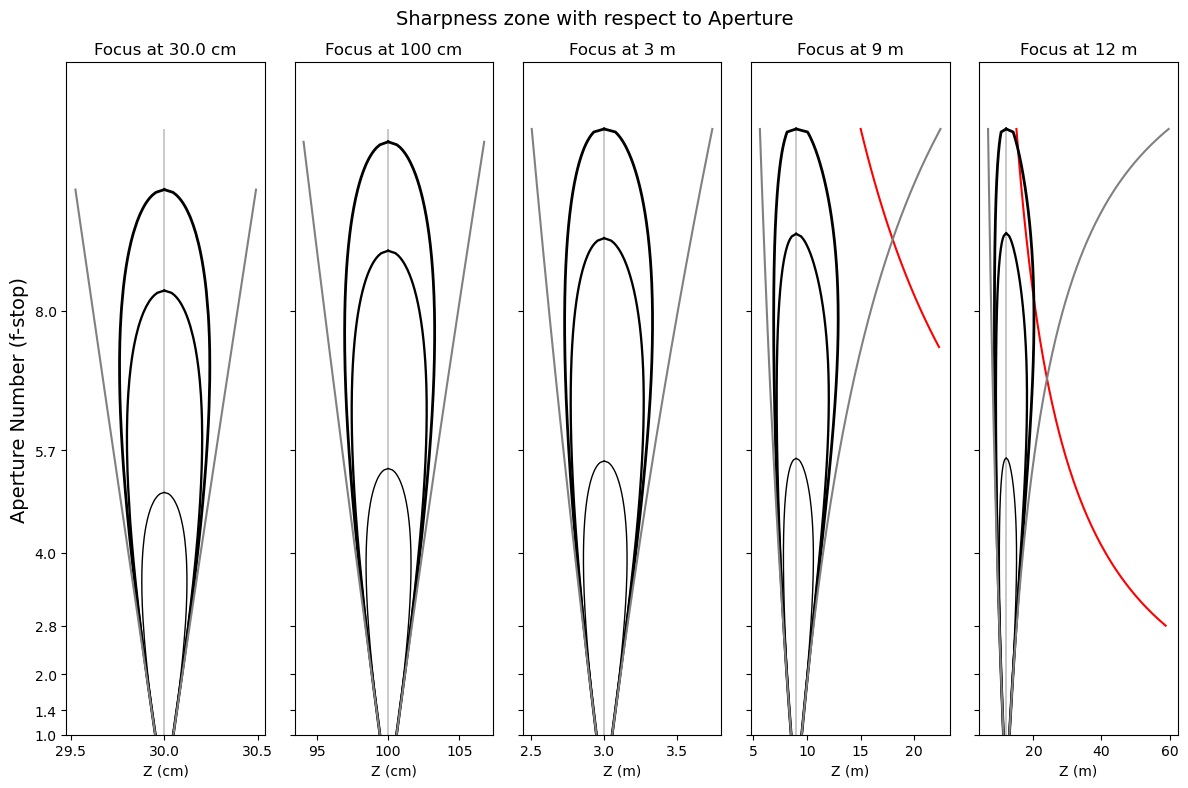

In [182]:
cam = camera.get_default_camera()
print(cam.H)

N_0 =1
N_max = 11
cam.update_aperture(11)
Z_list = [0.3, 1, 3, 9, 12]
effective_part_list = [1,0.6, 1/2]

fig, axes = plt.subplots(1, len(Z_list),sharey=True)
fig.set_size_inches((12,8))

axes[0].set_ylim(N_0, 1.1 * N_max)
cam.update_focus(Z_list[0])
N_list = np.array(cam.get_aperture_number_list())
N_list = N_list[N_list <= N_max]
axes[0].set_yticks(N_list)
axes[0].set_ylabel("Aperture Number (f-stop)", fontsize=14)
fig.suptitle("Sharpness zone with respect to Aperture", fontsize=14)

for ax,Z in zip(axes,Z_list):
    cam.update_focus(Z)

    for effective_part in effective_part_list:
        N_max_i = min(N_max, compute_maximum_sharp_aperture(cam, effective_part= effective_part))
        N= np.linspace(N_0, N_max_i, 200, endpoint=False)
        N = np.append(N,[N_max_i])
        z1, z2, z1_t, z2_t = [],[],[],[]
        H = []
        for N_i in N:
            cam.update_aperture(N_i)
            z1 += [cam.Z1]
            z2 += [cam.Z2]
            H += [cam.H]
            z1_t_i, z2_t_i = compute_sharpness_zone_including_diffraction(cam, wavelength= 546, effective_part= effective_part)
            z1_t += [z1_t_i]
            z2_t += [z2_t_i]
        z1_t[-1] = Z
        z2_t[-1] = Z
        ax.plot(np.array(z1_t) *(100 if Z<2 else 1), N, color="k", linestyle= "-", label="Z1 (diffraction)", linewidth= 1/effective_part)
        ax.plot(np.array(z2_t) *(100 if Z<2 else 1), N, color="k", linestyle= "-", label="Z2 (diffraction)", linewidth= 1/effective_part)

    ax.plot(np.array(z1) *(100 if Z<2 else 1), N, color="gray", linestyle= "-", label="Z1")
    ax.plot(np.array(z2) *(100 if Z<2 else 1), N, color="gray", linestyle= "-", label="Z2")
    if min(H) < max(z2) and max(H) > min(z1):
        h_select = np.array(H) < max(z2)
        H = np.array(H)[h_select]
        N = np.array(N)[h_select]
        ax.plot(np.array(H) *(100 if Z<2 else 1), N, color="red", linestyle= "-", label="H", zorder=0)
    
    ax.vlines(Z*(100 if Z<2 else 1),N_0,N_max, color="k", linewidth = 0.3)
    
    if Z < 2 :
        ax.set_xlabel("Z (cm)")
        ax.set_title("Focus at {} cm".format(Z*100))
    else:
        ax.set_xlabel("Z (m)")
        ax.set_title(f"Focus at {Z:} m")
    
fig.tight_layout()


In [120]:
cam.update_aperture(N_max)
compute_sharpness_zone_including_diffraction(cam, wavelength= 546, effective_part= effective_part)

(np.float64(10.701681653198438), np.float64(13.713422966848643))

In [184]:

def plot_diffraction_effect(cam, wavelength= 546, effective_part= 1, ax= None):

    plot_spread = 1
    zmin = max(cam.min_focus_distance/2, cam.Z1 - plot_spread* cam.depth_of_field)
    zmax = min(cam.Z2 + plot_spread* cam.depth_of_field, cam.Z + (cam.Z - zmin))
    zx = np.concatenate((np.linspace(zmin, cam.Z, 100), np.linspace( cam.Z, zmax, 100)))

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(f"Diffraction effect for N={cam.N:}")
    ax.set_xlim(xmin= zmin, xmax = zmax)
    ax.set_xlabel("Z (m)")
    ax.set_ylabel("Blur diameter on sensor (mm)")

    d_defocus = compute_defocus_diameter(cam, zx)
    defocus_artist, = ax.plot(zx, d_defocus, label= "defocus diameter", zorder= 10)
    d_diffraction = compute_diffraction_diameter(cam, zx, wavelength, effective_part)
    d_combined = compute_combined_diameter(cam, zx, wavelength, effective_part)
    combined_artist, = ax.plot(zx, d_combined, label= "combined effect diameter", zorder= 10)
    #d_defocus_conrad = compute_defocus_diameter_conrad(cam, zx)
    #conrad_artist, = ax.plot(zx, d_defocus_conrad, label= "defocus diameter (after Conrad)", zorder= 8)

    #ax2 = ax.twinx()
    diffraction_artist, = ax.plot(zx, d_diffraction, color="red", linewidth=0.65, label= "diffraction diameter (right axis)", zorder=12)

    ymin, ymax = 0, min(d_defocus.max(), 10 * cam.confusion_circle_diameter)
    ax.set_ylim(ymin,ymax)
    ax.vlines(cam.Z1, ymin= ymin, ymax= ymax, color="gray")
    ax.vlines(cam.Z2, ymin= ymin, ymax= ymax, color="gray")
    ax.hlines(y= cam.confusion_circle_diameter, xmin= zmin, xmax = zmax , color="gray")
    plt.legend(handles = [defocus_artist, diffraction_artist, combined_artist ])

    z1_t, z2_t = compute_sharpness_zone_including_diffraction(cam, wavelength, effective_part)
    if z1_t is not None:
        ax.vlines(z1_t, ymin= ymin, ymax= ymax, color="red")
        ax.vlines(z2_t, ymin= ymin, ymax= ymax, color="red")
        
def plot_difraction_effect_vs_N(cam, N= camera.Camera.get_aperture_number_list(),
                                zmin=None, zmax=None,
                                wavelength= 546, effective_part= 1, ax= None):

    plot_spread = 1
    cam.update_aperture(N[0])
    zmin = max(cam.min_focus_distance/2, cam.Z1 - plot_spread* cam.depth_of_field) if zmin is None else zmin
    zmax = min(cam.Z2 + plot_spread* cam.depth_of_field, cam.Z + (cam.Z - zmin)) if zmax is None else zmax
    zx = np.concatenate((np.linspace(zmin, cam.Z, 100), np.linspace( cam.Z, zmax, 100)))

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title("Diffraction effect with respect to N")
    ax.set_xlim(xmin= zmin, xmax = zmax)
    ax.set_xlabel("Z (m)")
    ax.set_ylabel("Blur diameter on sensor (mm)")
    
    
    for N_i in N:
        cam.update_aperture(N_i)
        d_combined = compute_combined_diameter(cam, zx, wavelength, effective_part)
        ax.plot(zx, d_combined, label= f"N={N_i:.1f}", zorder= 10)
        
        if N_i > compute_maximum_sharp_aperture(cam, wavelength, effective_part):
            break
        
    ax.hlines(y= cam.confusion_circle_diameter, xmin= zmin, xmax = zmax , color="k", zorder= 10)
    
    plt.legend()


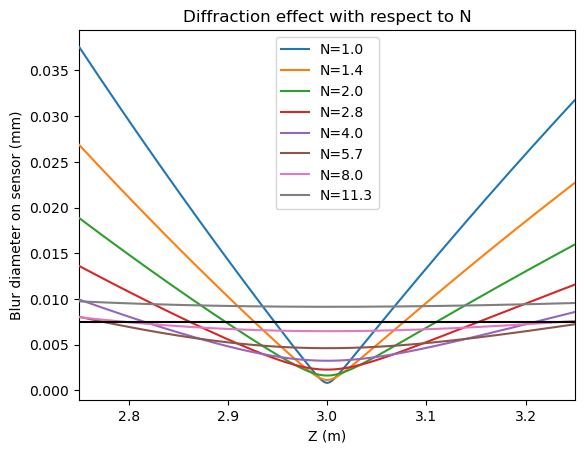

In [122]:
cam.update_focus(3)
plot_difraction_effect_vs_N(cam, effective_part= 0.6, zmin= 2.75, zmax= 3.25)

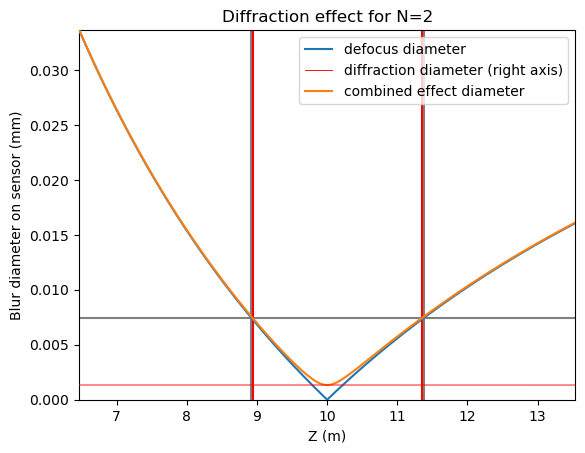

In [123]:
cam.update_aperture(N= 2)
cam.update_focus(Z=10)
plot_diffraction_effect(cam, effective_part= 1/2)

In [124]:
camera.Camera.get_aperture_number_list()

[1.0, 1.4, 2.0, 2.8, 4.0, 5.7, 8.0, 11.3, 16.0, 22.6]

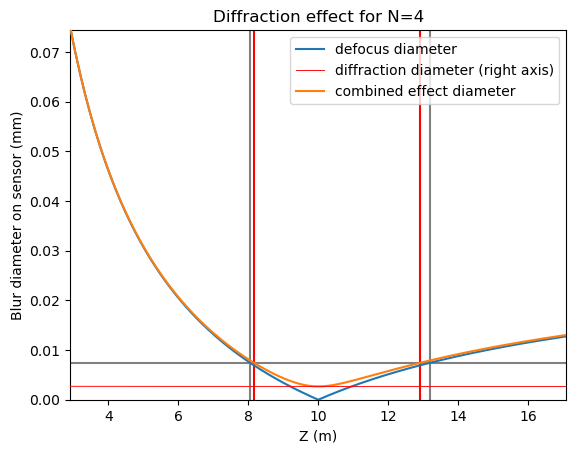

In [183]:
cam.update_aperture(N= 4)
cam.update_focus(Z=10)
plot_diffraction_effect(cam, effective_part= 1/2)

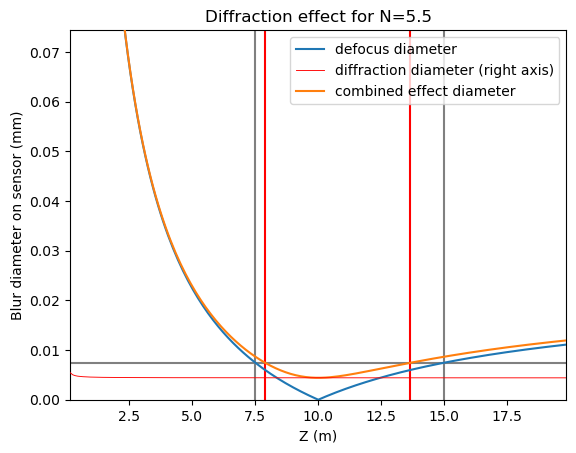

In [185]:
cam.update_aperture(N= 5.5)
cam.update_focus(Z=10)
plot_diffraction_effect(cam, effective_part= 0.6)

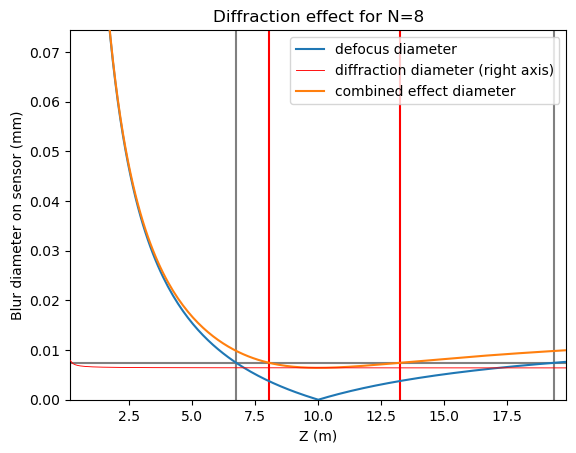

In [127]:
cam.update_aperture(N= 8)
cam.update_focus(Z=10)
plot_diffraction_effect(cam, effective_part= 0.6)

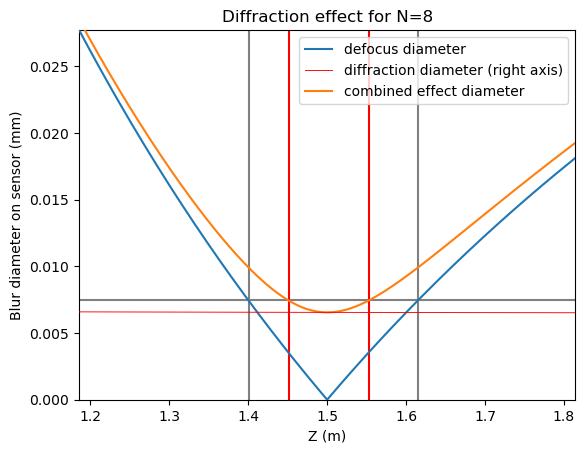

In [181]:
cam.update_focus(Z= 1.5)
cam.update_aperture(N= 8)
plot_diffraction_effect(cam, effective_part= 0.6)

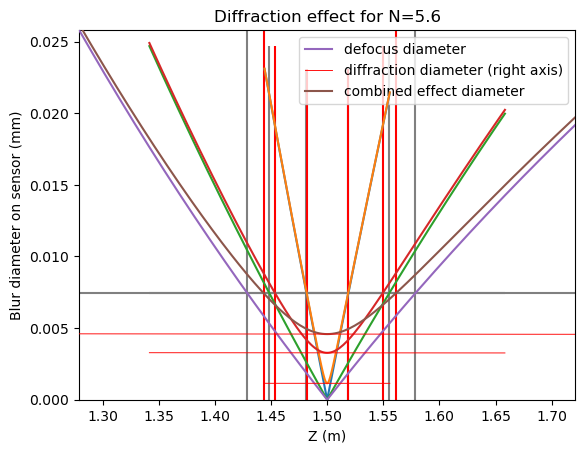

In [129]:
cam.update_aperture(N=1.4)
plot_diffraction_effect(cam, effective_part= 0.6)

cam.update_aperture(N= 4)
plot_diffraction_effect(cam, effective_part= 0.6, ax= plt.gca())

cam.update_aperture(N= 5.6)
plot_diffraction_effect(cam, effective_part= 0.6, ax= plt.gca())

In [130]:
from scipy import special

In [131]:
def intensity_within_diameter(ratio_diam):
    airy_d_halfiam = special.jn_zeros(1,1)
    x= ratio_diam * airy_d_halfiam
    return (1 - special.jv(0, x)**2 - special.jv(1,x)**2)
def relative_intensity_within_diameter(ratio_diam):
    return intensity_within_diameter(ratio_diam)/intensity_within_diameter(1)

In [132]:
relative_intensity_within_diameter(0.6)

array([0.84174996])

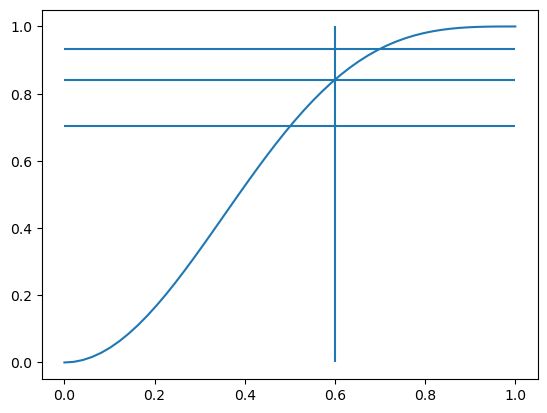

In [215]:
ratio_diam = np.linspace(0, 1)
plt.plot(ratio_diam, relative_intensity_within_diameter(ratio_diam))
plt.hlines(relative_intensity_within_diameter(1/2), 0,1)
plt.hlines(relative_intensity_within_diameter(0.6), 0,1)
plt.hlines(relative_intensity_within_diameter(0.7), 0,1)
plt.vlines(0.6, 0,1)

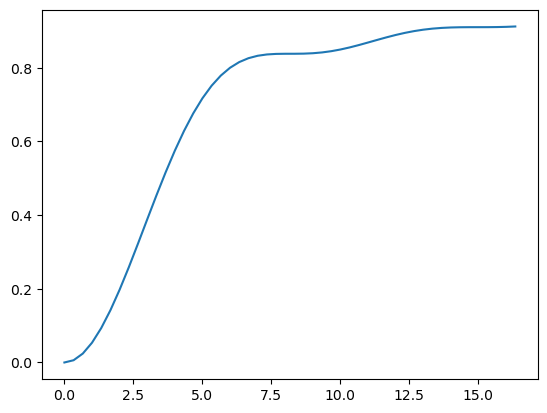

In [216]:
zx = cam.Z
q = np.linspace(0, cam._compute_diffraction_diameter(zx))
plt.plot(q, cam._compute_diffraction_intensity_within_distance(q, zx))


In [213]:
importlib.reload(camera)
cam = camera.get_default_camera()
cam.update_aperture(N=11)

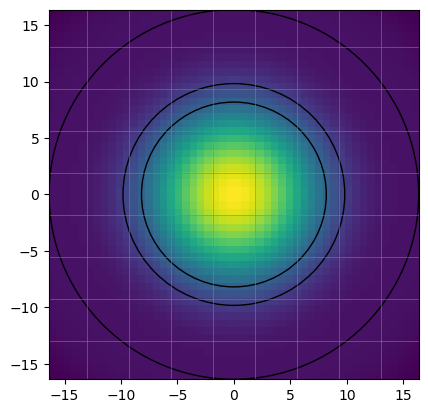

In [191]:
cam = camera.get_default_camera()
cam.update_focus(0.3)
cam.update_aperture(22)

zx= cam.Z
airy_d_half = 0.5* cam._compute_diffraction_diameter( zx)

x,y = np.meshgrid(np.linspace(-1,1),np.linspace(-1,1))
plt.imshow(1-relative_intensity_within_diameter(np.sqrt(x**2+y**2)), extent=(-airy_d_half,airy_d_half,-airy_d_half,airy_d_half))
plt.gca().add_patch(plt.Circle((0,0), 1/2*airy_d_half, fill=False))
plt.gca().add_patch(plt.Circle((0,0), 0.6*airy_d_half, fill=False))
plt.gca().add_patch(plt.Circle((0,0), 1*airy_d_half, fill=False))

pixel_grid_line_width = 0.4

d = 2 * airy_d_half
p = cam.pixel_pitch * 1000
for line_i in range(int(1 + (d - p)//(2*p))):
    line_p_i = (0.5 + line_i) * p
    plt.hlines(line_p_i, -airy_d_half,airy_d_half, color= "grey", linewidth= pixel_grid_line_width)
    plt.hlines(-line_p_i, -airy_d_half,airy_d_half, color= "grey", linewidth= pixel_grid_line_width)
    plt.vlines(line_p_i, -airy_d_half,airy_d_half, color= "grey", linewidth= pixel_grid_line_width)
    plt.vlines(-line_p_i, -airy_d_half,airy_d_half, color= "grey", linewidth= pixel_grid_line_width)

In [192]:
def relative_diffraction_intensity(q, z, f, N, wavelength= 546):
    """Compute the intensity of the diffraction pattern normalised by its intensity at the center

    :param q: distance to the center of the pattern in micrometers
    :type q: float
    :param z: object distance in meters
    :type z: float
    :param f: focal in mm
    :type f: float
    :param N: aperture number
    :type N: float
    :param wavelength: wavelength of light in nm default is 456 nm
    :type wavelength: float
    :return: the relative intensity
    :rtype: float
    """    
    f = 1000 * f
    m = f/z/1e6
    k = 2 * np.pi / wavelength * 1000
    a = f/2/N
    sin_th = q/np.sqrt(q**2 + f**2)
    x = k*a*sin_th / (1+m)
    return (2 * special.jv(1,x)/x)**2

In [194]:
cam._compute_diffraction_diameter(cam.Z) / 2

np.float64(16.364348)

In [195]:
cam.wavelength_nm

546

(0.0, 1.05)

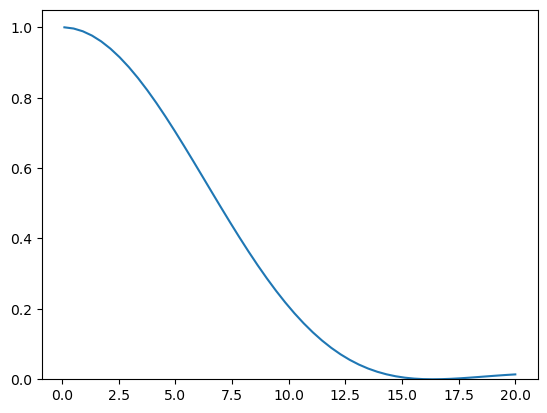

In [196]:
f = cam.focal # mm
N = cam.N
z = cam.Z

q = np.linspace(0.1,20)
plt.plot(q,relative_diffraction_intensity(q, z, f, N))
plt.ylim(0,1.05)

ratio cumulated:  0.841938329148337


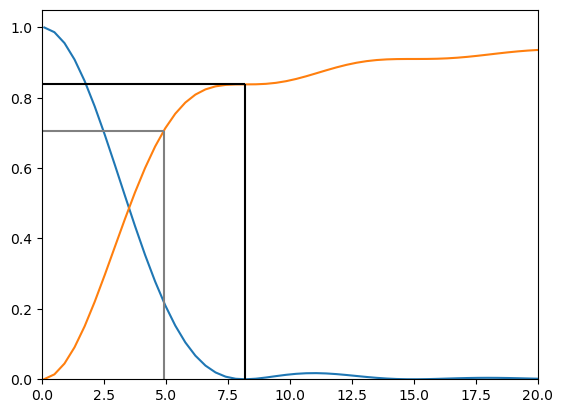

In [226]:
f = cam.focal # mm
N = cam.N
z = cam.Z

q = np.linspace(0.1,20)
plt.plot(q,cam._compute_diffraction_intensity(q, zx= z))
plt.plot(q,cam._compute_diffraction_intensity_within_distance(q, zx= z))
plt.ylim(0,1.05)
plt.xlim(0,20)

r_airy = cam._compute_diffraction_diameter(cam.Z)/2

cumul_r_airy = cam._compute_diffraction_intensity_within_distance(r_airy, zx= z)
cumul_0_6 = cam._compute_diffraction_intensity_within_distance(0.6*r_airy, zx= z)
plt.hlines(cumul_0_6, xmin=0, xmax=0.6*r_airy, color = "gray")
plt.hlines(cumul_r_airy, xmin=0, xmax=r_airy, color = "k")
plt.vlines(r_airy, ymin=0, ymax=cumul_r_airy, color = "k")
plt.vlines(0.6*r_airy, ymin=0, ymax=cumul_0_6, color = "gray")

print("ratio cumulated: ", cumul_0_6/cumul_r_airy)


Text(0, 0.5, 'Distance to pattern center (micrometers)')

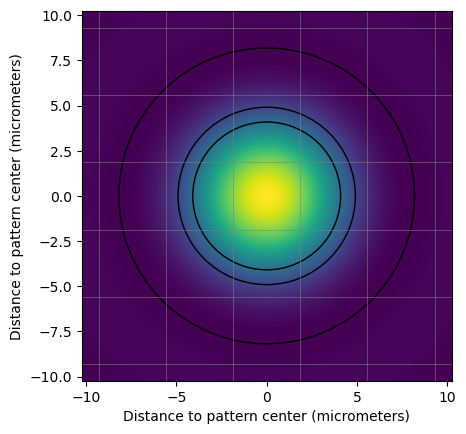

In [ ]:
cam = camera.get_default_camera()
cam.update_focus(0.3)
cam.update_aperture(11)

zx= cam.Z
airy_d_half = 0.5* cam._compute_diffraction_diameter(zx)

bound = 1.25 * airy_d_half
grid_pix = np.linspace(-bound,bound, 150)
x,y = np.meshgrid(grid_pix,grid_pix)
plt.imshow(cam._compute_diffraction_intensity(np.sqrt(x**2+y**2), zx), extent=(-bound,bound,-bound,bound))
plt.gca().add_patch(plt.Circle((0,0), 1/2*airy_d_half, fill=False))
plt.gca().add_patch(plt.Circle((0,0), 0.6*airy_d_half, fill=False))
plt.gca().add_patch(plt.Circle((0,0), 1*airy_d_half, fill=False))

pixel_grid_line_width = 0.4

d = 2 * bound
p = cam.pixel_pitch * 1000
for line_i in range(int(1 + (d - p)//(2*p))):
    line_p_i = (0.5 + line_i) * p
    plt.hlines(line_p_i, -bound,bound, color= "grey", linewidth= pixel_grid_line_width)
    plt.hlines(-line_p_i, -bound,bound, color= "grey", linewidth= pixel_grid_line_width)
    plt.vlines(line_p_i, -bound,bound, color= "grey", linewidth= pixel_grid_line_width)
    plt.vlines(-line_p_i, -bound,bound, color= "grey", linewidth= pixel_grid_line_width)

plt.xlabel("Distance to pattern center (micrometers)")

In [186]:
cam.pixel_pitch

np.float64(0.0037187500000000003)

In [55]:
 (d - p)%(2*p)

np.float64(3.4220564)

In [195]:
intensity_within_diameter(2/3)

array([0.76091725])

In [187]:
special.jn_zeros(1,1)

array([3.83170597])

## Testing rendered

In [43]:
import pyvista as pv

In [44]:
mesh = pv.Sphere()

In [45]:
mesh.point_data.set_array(np.arange(mesh.n_points).astype(float),"val1")

In [46]:

# creating a plotter and adding the object (without color)
plotter = pv.Plotter()
actor = plotter.add_mesh(mesh)
plotter.show()

Widget(value='<iframe src="http://localhost:54288/index.html?ui=P_0x2832674c750_4&reconnect=auto" class="pyvis…

In [47]:
mesh.point_data["val2"] = np.arange(mesh.n_points).astype(float)

In [ ]:
scalar_name = "val1"
actor.mapper.scalar_visibility = True
actor.mapper.array_name = scalar_name
actor.mapper.scalar_range = 0, mesh.n_points
actor.mapper.lookup_table.cmap = "viridis"


for key in list(plotter.scalar_bars.keys()):
    plotter.remove_scalar_bar(key)
plotter.add_scalar_bar(scalar_name, actor)

plotter.update()

In [51]:
mesh.set_active_scalars(None)
actor.mapper.scalar_visibility = False
actor.mapper.array_name = None
actor.mapper.scalar_range = 0, 1
actor.mapper.lookup_table.cmap = "viridis"

for key in list(plotter.scalar_bars.keys()):
    plotter.remove_scalar_bar(key)
    
plotter.update()

In [6]:
import pyvista as pv
obj = pv.Sphere()

plotter = pv.Plotter()
actor = plotter.add_mesh(obj)

plotter.show()

Widget(value='<iframe src="http://localhost:50687/index.html?ui=P_0x22662cbcb50_1&reconnect=auto" class="pyvis…

In [11]:
obj.point_data.set_array(obj.points[:,2],"val")

actor.mapper.scalar_visibility = True
actor.mapper.array_name = "val"
actor.mapper.color_mode = "map"
plotter.update()


In [24]:
obj.point_data.set_array(obj.points[:,2],"val")
obj.set_active_scalars("val")

actor.mapper.array_name = "val"
actor.mapper.color_mode = "map"
actor.mapper.dataset = obj
actor.mapper.interpolate_before_map = True
actor.mapper.lookup_table = pv.LookupTable(cmap= "viridis", scalar_range= [-5,5])
actor.mapper.scalar_range = [-5,5]
actor.mapper.scalar_visibility = True
plotter.update()

In [19]:
actor.mapper

DataSetMapper (0x22662cfdea0)
  Scalar visibility:           True
  Scalar range:                (-5.0, 5.0)
  Interpolate before mapping:  True
  Scalar map mode:             default
  Color mode:                  map

Attached dataset:
PolyData (0x22662cbafe0)
  N Cells:    1680
  N Points:   842
  N Strips:   0
  X Bounds:   -4.993e-01, 4.993e-01
  Y Bounds:   -4.965e-01, 4.965e-01
  Z Bounds:   -5.000e-01, 5.000e-01
  N Arrays:   2

In [29]:
import pyvista as pv

# creating an object
obj = pv.Sphere()

# creating a plotter and adding the object (without color)
plotter = pv.Plotter()
actor = plotter.add_mesh(obj)
plotter.show()

# doing some computation and creating a scalar field
# I found this solution in the forum to add the scalar field without showing it
# which is the intended behavior at this stage
obj.point_data.set_array(obj.points[:,1],"val1")
obj.point_data.set_array(obj.points[:,2],"val2")

# later on I would like to show a given scalar field on the object
# this is where I am missing something
obj.set_active_scalar = "val1"
actor.mapper.scalar_visibility = True
actor.mapper.array_name = "val1"
plotter.update()

Widget(value='<iframe src="http://localhost:50687/index.html?ui=P_0x226000072d0_7&reconnect=auto" class="pyvis…

In [2]:
importlib.reload(target)
importlib.reload(camera)
importlib.reload(graphics)

<module 'pypho.design.graphics' from 'c:\\Users\\glaurent\\Documents\\Dev\\Projects\\PhotogrammetryTools\\notebooks\\01_photogrammetric_design\\../..\\pypho\\design\\graphics.py'>

In [2]:
cam = camera.get_default_camera()
obj = target.Well()
cam.move([1,0,0.5])
cam.orbit(-160, obj.center)

viewer = graphics.Viewer3D(cam,obj,
                           target_object_texture= target.get_rock_texture()
)
viewer.show()

Widget(value='<iframe src="http://localhost:62986/index.html?ui=P_0x2da3801d010_1&reconnect=auto" class="pyvis…

In [2]:
cam = camera.get_default_camera()
obj = target.DrillCore(radius= 0.0125, height= 0.05, translation=[1,0,0])

viewer = graphics.Viewer3D(cam,obj)
viewer.show()

Widget(value="<iframe src='http://localhost:56390/index.html?ui=P_0x20c13242200_1&reconnect=auto' style='width…

In [3]:
cam.attach_target(obj)
viewer.update()

In [5]:
cam.move([np.linalg.norm(cam.target_point - cam.location) - cam.min_focus_distance, 0,0])
viewer.update()

In [6]:
cam.focus_on()
viewer.update()

In [10]:
cam.update_aperture(16)
viewer.update()

In [12]:
cam.setup_lens(focal=90, min_focus_distance=0.3)
cam.update_aperture(16)
cam.focus_on()
viewer.update()

# Camera database

In [3]:
# after https://www.dxomark.com/Cameras/Sony/A7RIV---Specifications
camera.CameraRegistry.register_camera(
    uid="A7RIV", name= "Sony Alpha 7RIV",
    sensor_width= 35.7, sensor_height= 23.8,
    nb_pixel_width= 9600, nb_pixel_height= 6376
)

camera.CameraRegistry.register_lens(
    uid= "FE35",
    name= "Sony FE 35 mm f/1.4 Zeiss Distagon T*",
    focal= 35,
    min_focus_distance= 0.3 
)


In [4]:
camera.CameraRegistry.camera_base.head()

name  sensor_width  sensor_height  nb_pixel_width  \
uid                                                                   
A7RIV  Sony Alpha 7RIV          35.7           23.8            9600   

       nb_pixel_height  pixel_size  nb_pixel  MPix  
uid                                                 
A7RIV             6376    0.003719  61209600  61.2

In [5]:
camera.CameraRegistry.lens_base.head()

name  focal_min  focal_max  \
uid                                                                 
FE35  Sony FE 35 mm f/1.4 Zeiss Distagon T*         35         35   

      focal_fixed  min_focus_distance  
uid                                    
FE35         True                 0.3

In [6]:
a7riv = camera.CameraRegistry.get_camera("A7RIV","FE35")
print(a7riv)

Camera settings:
  shots: []
  target_object: None
  orientation: landscape
  location: [0. 0. 0.]
  yaw: 0
  pitch: 0 micron
  roll: 0
  rotation: <scipy.spatial.transform._rotation.Rotation object at 0x000002199E02C120>
  dir_vector: [1. 0. 0.]
  w_vector: [0. 1. 0.]
  h_vector: [0. 0. 1.]
  confusion_method: bouillot
  cam_id: A7RIV
  camera_characteristics: name               Sony Alpha 7RIV
sensor_width                  35.7
sensor_height                 23.8
nb_pixel_width                9600
nb_pixel_height               6376
pixel_size                0.003719
nb_pixel                  61209600
MPix                          61.2
Name: A7RIV, dtype: object
  camera_type: Sony Alpha 7RIV
  name: A7RIV
  sensor_width: 35.7 mm
  sensor_height: 23.8 mm
  pixel_size: 0.0037187500000000003 mm
  confusion_circle_diameter: 0.0074375000000000005
  lens_id: FE35
  N: 2.8
  lens_characteristics: name                  Sony FE 35 mm f/1.4 Zeiss Distagon T*
focal_min                           

In [7]:
import pyvista as pv
import matplotlib.pyplot as plt

In [15]:
obj = target.CubeSample(translation= [2,0,0], rotation=[0,90])
cam = camera.get_default_camera()
cam.move([1.75,0,0])

cam.attach_target(obj, translate=True)

c:\Users\glaurent\Documents\Outils\Anaconda\envs\pypho\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\glaurent\Documents\Outils\Anaconda\envs\pypho\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


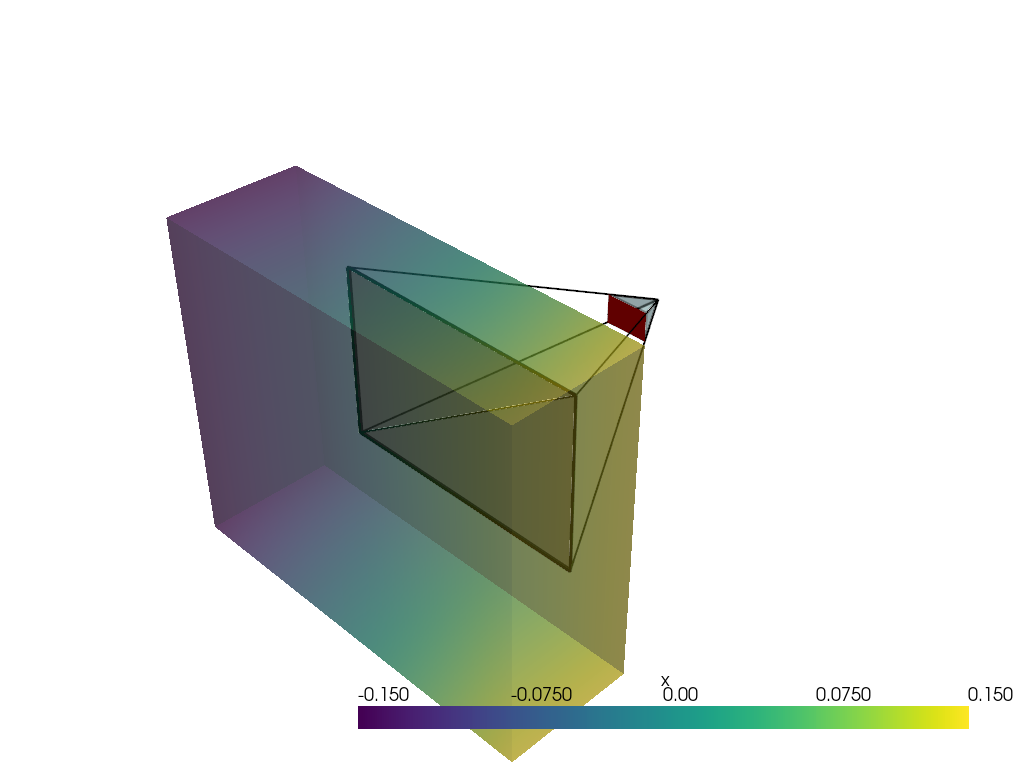

In [16]:
viewer = graphics.Viewer3D(cameras=cam, objects=obj,
                           plot_visibility_object=True,
                           target_object_opacity=0.5)
viewer.show()
viewer.set_active_scalars("resolution", obj)

In [17]:
vis_object = cam.get_visibility_object()
nodes = vis_object.points[:-1]
nsub = 2

In [18]:

frame_nodes = np.concatenate((
    np.linspace(nodes[0], nodes[1], nsub, endpoint=False),
    np.linspace(nodes[1], nodes[2], nsub, endpoint=False),
    np.linspace(nodes[2], nodes[3], nsub, endpoint=False),
    np.linspace(nodes[3], nodes[0], nsub, endpoint=False)
))

In [19]:
frame_nodes

array([[ 1.951  , -0.10251, -0.01834],
       [ 1.951  ,  0.     , -0.01834],
       [ 1.951  ,  0.10251, -0.01834],
       [ 1.951  ,  0.10251,  0.05   ],
       [ 1.951  ,  0.10251,  0.11834],
       [ 1.951  ,  0.     ,  0.11834],
       [ 1.951  , -0.10251,  0.11834],
       [ 1.951  , -0.10251,  0.05   ]])

c:\Users\glaurent\Documents\Outils\Anaconda\envs\pypho\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\glaurent\Documents\Outils\Anaconda\envs\pypho\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


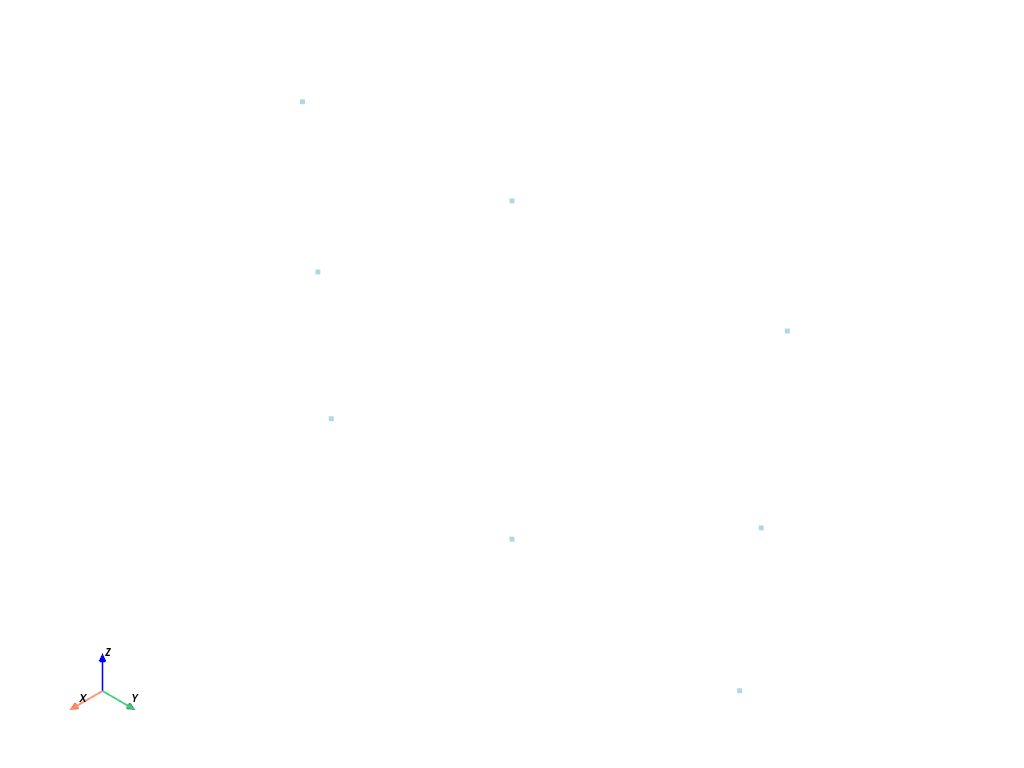

In [21]:
import pyvista as pv
pv.wrap(frame_nodes).plot()

In [22]:

frame_lines = [i for line_i in range(len(frame_nodes)-1) for i in [2,line_i,line_i+1]]+[2,len(frame_nodes),0]


In [23]:
frame_lines

[2, 0, 1, 2, 1, 2, 2, 2, 3, 2, 3, 4, 2, 4, 5, 2, 5, 6, 2, 6, 7, 2, 8, 0]

In [24]:
[len(frame_nodes)+1]+list(range(len(frame_nodes)))+[0]

[9, 0, 1, 2, 3, 4, 5, 6, 7, 0]

c:\Users\glaurent\Documents\Outils\Anaconda\envs\pypho\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\glaurent\Documents\Outils\Anaconda\envs\pypho\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


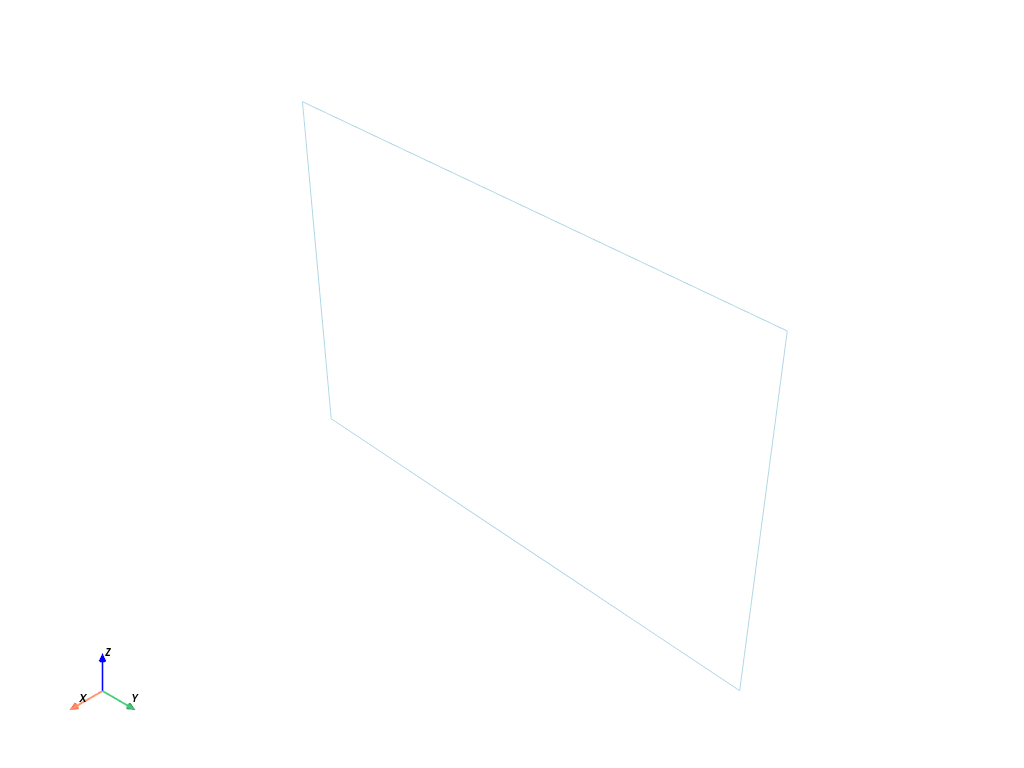

In [25]:
frame_lines = [len(frame_nodes)+1]+list(range(len(frame_nodes)))+[0]
frame = pv.PolyData(frame_nodes, lines=frame_lines)
frame.plot()

In [26]:
cam.move([-0.1,0,0])
cam.turn(10,"up")

In [27]:
vis_object = cam.get_visibility_object()
start = vis_object.points[-1]
nodes = vis_object.points[:-1]

nsub= 2
frame_nodes = np.concatenate((
    np.linspace(nodes[0], nodes[1], nsub, endpoint=False),
    np.linspace(nodes[1], nodes[2], nsub, endpoint=False),
    np.linspace(nodes[2], nodes[3], nsub, endpoint=False),
    np.linspace(nodes[3], nodes[0], nsub, endpoint=False)
))

#hit, ray_id, cell_id = obj.multi_ray_trace(start, directions,first_point=True)
#hit, cell_id = obj.ray_trace(start, nodes[0])
hits = [obj.ray_trace(start, node_i, first_point=True)[0] for node_i in frame_nodes ]
hit_bool = [len(hit_i)>0 for hit_i in hits]
print(hits)
print(hit_bool)
hit_bool and hit_bool[1:]+[hit_bool[0]]

[array([ 1.95      , -0.14657305,  0.00367531], dtype=float32), array([1.95      , 0.        , 0.00367531], dtype=float32), array([1.95      , 0.14657305, 0.00367531], dtype=float32), array([], shape=(0, 3), dtype=float32), array([], shape=(0, 3), dtype=float32), array([], shape=(0, 3), dtype=float32), array([], shape=(0, 3), dtype=float32), array([], shape=(0, 3), dtype=float32)]
[True, True, True, False, False, False, False, False]


[True, True, False, False, False, False, False, True]

In [32]:
hit_bool and hit_bool[1:]+[hit_bool[0]]

TypeError: bad operand type for unary ~: 'list'

In [41]:
for node_i in frame_nodes:
    print(obj.ray_trace(start, node_i, first_point=True)[0])

[ 1.95       -0.14657305  0.00367531]
[1.95       0.         0.00367531]
[1.95       0.14657305 0.00367531]
[]
[]
[]
[]
[]


In [ ]:
frame_lines = [len(frame_nodes)+1]+list(range(len(frame_nodes)))+[0]
visible_edge = pv.PolyData(hits, lines=frame_lines)

plotter = pv.Plotter()
plotter.add_mesh(vis_object, opacity=0.5)
plotter.add_mesh(frame_nodes, color= "red")
plotter.add_mesh(start, color= "green")
plotter.add_mesh(obj, opacity=0.3)
plotter.add_mesh(visible_edge, color= "blue")
plotter.show()

In [31]:
hits

array([1.95     , 1.9570142, 1.95     , 1.95     , 1.9570142],
      dtype=float32)

In [54]:
import vtk

In [50]:
list(cam.location)

[1.75, 0.0, 0.05000000074505806]

In [51]:
n=len(nodes)
origins = np.repeat([start],len(nodes),axis=0)
obj.multi_ray_trace([list(cam.location)]*n, 0.5*(nodes-start), first_point=True, retry=True)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [14]:
cam.attach_target(obj, rotate=False)

In [56]:
cam2 = cam.copy()
cam2.orbit(45, obj.center)

In [57]:
viewer = graphics.Viewer3D(cameras=[cam, cam2], objects=[obj])
viewer.show()
viewer.set_active_scalars("resolution", obj)

Widget(value="<iframe src='http://localhost:61261/index.html?ui=P_0x1ce7db88790_11&reconnect=auto' style='widt…

In [58]:
viewer.set_active_scalars("resolution", obj)

In [59]:
cam.focus_on(method=np.max)
viewer.update()

In [60]:
pv_cam = pv.Camera()
pv_cam.clipping_range = (0.3,1.0)
pv_cam.position = cam.location
pv_cam.up = cam.h_vector
pv_cam.focal_point = cam.location + cam.focal/1000 * cam.dir_vector

In [61]:
plotter = pv.Plotter()
plotter.add_mesh(obj)
plotter.camera = pv_cam
plotter.show()

Widget(value="<iframe src='http://localhost:61261/index.html?ui=P_0x1ce7dc5bbe0_12&reconnect=auto' style='widt…

In [67]:
coplot = pv.Plotter(shape=(1,2))
viewer = graphics.Viewer3D(cameras=[cam, cam2], objects=[obj])
viewer.plotter=coplot
viewer.show()
viewer.set_active_scalars("resolution", obj)

coplot.subplot(0,1)
coplot.add_mesh(obj)
coplot.camera.position = cam.location
coplot.camera.up = cam.h_vector
coplot.camera.focal_point = cam.location + cam.focal/1000 * cam.dir_vector

Widget(value="<iframe src='http://localhost:61261/index.html?ui=P_0x1ce7a333130_21&reconnect=auto' style='widt…

In [68]:
import scipy 

In [44]:
cam2.turn(10, "down")

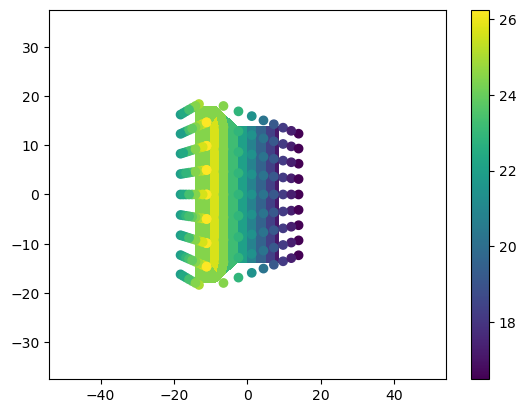

In [83]:
sub_obj = obj.subdivide(3)
points = sub_obj.points
visible = cam2.get_visible_points(points, sub_obj.point_normals)
visible_points = points[visible]

cam_coords = cam2._compute_camera_coordinates(visible_points)
angles = cam2._compute_deviation_angles(cam_coords)
res = cam2.compute_resolution(visible_points)

w = np.linspace(-cam2.fov_w, cam2.fov_w, 20)
h = np.linspace(-cam2.fov_h, cam2.fov_h, 20)
wi, hi = np.meshgrid(w,h)

res_i = scipy.interpolate.griddata(angles, res, np.array([wi.ravel(),hi.ravel()]).T).reshape(wi.shape)
plt.contourf(wi,hi,res_i, extent=(-cam2.fov_w, cam2.fov_w,-cam2.fov_h, cam2.fov_h))
plt.scatter(*angles.T, c=res)
plt.colorbar()

# TODO : use tricontourf but with pyvista triangles

In [99]:
points = sub_obj.points
visible = cam2.get_visible_points(points, sub_obj.point_normals)
visible_points = points[visible]
cam_coords = cam2._compute_camera_coordinates(points )
angles = cam2._compute_deviation_angles(cam_coords)
res = cam2.compute_resolution(points)
triangles = sub_obj.faces.reshape((-1,4))[:,1:]
triangles

array([[  0, 151, 150],
       [151,  55, 152],
       [152,  54, 150],
       ...,
       [484, 148, 485],
       [485, 145, 483],
       [484, 485, 483]], dtype=int64)

In [108]:
visible_triangles = triangles[np.all(visible[triangles], axis=1)]

In [109]:
visible_triangles

array([[263,  87, 264],
       [ 87, 266, 265],
       [266,  35, 267],
       [267,  88, 265],
       [266, 267, 265],
       [ 88, 269, 268],
       [269,  34, 270],
       [270,  86, 268],
       [269, 270, 268],
       [ 87, 265, 264],
       [265,  88, 268],
       [268,  86, 264],
       [265, 268, 264],
       [ 35, 272, 271],
       [272,  90, 273],
       [273,  89, 271],
       [272, 273, 271],
       [ 90, 275, 274],
       [276,  91, 274],
       [275, 276, 274],
       [ 91, 278, 277],
       [278,  36, 279],
       [279,  89, 277],
       [278, 279, 277],
       [ 90, 274, 273],
       [274,  91, 277],
       [277,  89, 273],
       [274, 277, 273],
       [ 36, 281, 280],
       [281,  93, 282],
       [282,  92, 280],
       [281, 282, 280],
       [ 93, 284, 283],
       [284,  10, 285],
       [285,  94, 283],
       [284, 285, 283],
       [ 94, 287, 286],
       [287,  34, 288],
       [288,  92, 286],
       [287, 288, 286],
       [ 93, 283, 282],
       [283,  94

In [113]:
from matplotlib.tri import Triangulation
tri = Triangulation(x=angles[:,0], y=angles[:,1], triangles= triangles)

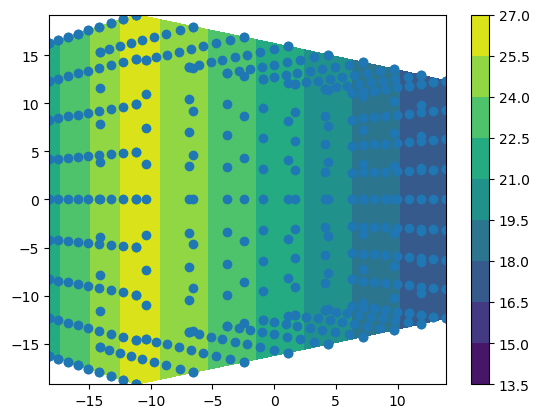

In [115]:
plt.scatter(x=angles[:,0], y=angles[:,1], zorder= 2)
plt.tricontourf(tri, res)
plt.colorbar()

In [39]:
sub_obj.plot_normals(mag=0.03,scalars=visible)

Widget(value="<iframe src='http://localhost:61261/index.html?ui=P_0x1ce77a56980_9&reconnect=auto' style='width…

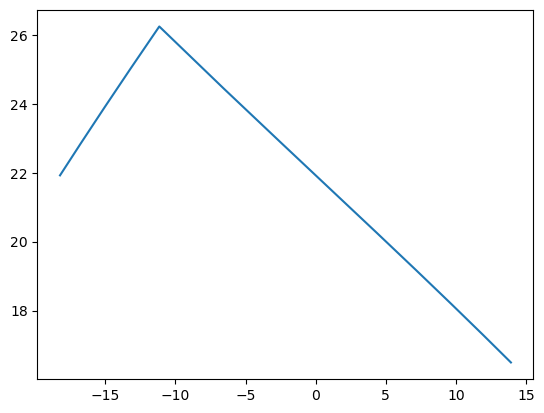

In [42]:
i = np.argsort(angles[:,0])
plt.plot(angles[i,0],res[i])

In [315]:
np.array([wi.ravel(),hi.ravel()]).T

array([[-54.04316318, -37.55606644],
       [-48.35440916, -37.55606644],
       [-42.66565514, -37.55606644],
       [-36.97690112, -37.55606644],
       [-31.28814711, -37.55606644],
       [-25.59939309, -37.55606644],
       [-19.91063907, -37.55606644],
       [-14.22188505, -37.55606644],
       [ -8.53313103, -37.55606644],
       [ -2.84437701, -37.55606644],
       [  2.84437701, -37.55606644],
       [  8.53313103, -37.55606644],
       [ 14.22188505, -37.55606644],
       [ 19.91063907, -37.55606644],
       [ 25.59939309, -37.55606644],
       [ 31.28814711, -37.55606644],
       [ 36.97690112, -37.55606644],
       [ 42.66565514, -37.55606644],
       [ 48.35440916, -37.55606644],
       [ 54.04316318, -37.55606644],
       [-54.04316318, -33.60279629],
       [-48.35440916, -33.60279629],
       [-42.66565514, -33.60279629],
       [-36.97690112, -33.60279629],
       [-31.28814711, -33.60279629],
       [-25.59939309, -33.60279629],
       [-19.91063907, -33.60279629],
 

In [308]:
angles

array([[-18.43494768,  15.52410899],
       [-15.25512054,  12.80426677],
       [ 15.25512054,  12.80426677],
       [ 18.43494768,  15.52410899],
       [-18.43494768, -15.52410987],
       [ 18.43494768, -15.52410987],
       [ 15.25512054, -12.80426751],
       [-15.25512054, -12.80426751],
       [-18.43494768,  15.52410899],
       [-18.43494768,  15.52410899],
       [-15.25512054,  12.80426677],
       [-15.25512054,  12.80426677],
       [ 15.25512054,  12.80426677],
       [ 15.25512054,  12.80426677],
       [ 18.43494768,  15.52410899],
       [ 18.43494768,  15.52410899],
       [-18.43494768, -15.52410987],
       [-18.43494768, -15.52410987],
       [ 18.43494768, -15.52410987],
       [ 18.43494768, -15.52410987],
       [ 15.25512054, -12.80426751],
       [ 15.25512054, -12.80426751],
       [-15.25512054, -12.80426751],
       [-15.25512054, -12.80426751],
       [  0.        ,  15.52410899],
       [-16.69924486,  14.03624307],
       [  0.        ,  14.03624307],
 

In [197]:
add = list(viewer.plotter.actors)[-2]
actor = viewer.plotter.actors[add]

In [206]:
actor.mapper.set_scalars(obj.point_data["resolution"], scalars_name="resolution")
viewer.plotter.update()

In [207]:
actor

Actor (0x23f6d4b4460)
  Center:                     (2.0, 0.0, 0.05000000074505806)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    1.950E+00, 2.050E+00
  Y Bounds                    -1.500E-01, 1.500E-01
  Z Bounds                    -7.500E-02, 1.750E-01
  User matrix:                Unset
  Has mapper:                 True

Property (0x23f86c9e2c0)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Interpolation:       

In [163]:
cam_dict = {}

In [178]:
cam_dict[obj] = dict(test="ahhh")

TypeError: unhashable type: 'CubeSample'

In [165]:
cam_dict[cam]

{'test': 'ahhh'}

In [158]:
obj.plot()

Widget(value="<iframe src='http://localhost:53577/index.html?ui=P_0x23f42a9ab90_23&reconnect=auto' style='widt…

In [125]:
focal = 35
z = np.linspace(0,3,10)
sensor_pixel_size = cam.pixel_size

1000 *z / focal * sensor_pixel_size

array([0.        , 0.03541667, 0.07083333, 0.10625   , 0.14166667,
       0.17708333, 0.2125    , 0.24791667, 0.28333333, 0.31875   ])

In [126]:
cam._compute_pixel_size(z)

array([0.        , 0.03541667, 0.07083333, 0.10625   , 0.14166667,
       0.17708333, 0.2125    , 0.24791667, 0.28333333, 0.31875   ])

In [127]:
cam._compute_resolution(z)

c:\Users\glaurent\Documents\Dev\Projects\PhotogrammetryTools\notebooks\01_photogrammetric_design\../..\pypho\design\camera.py:258: RuntimeWarning: divide by zero encountered in divide
  return 1/cls._compute_pixel_size(z, focal, sensor_pixel_size)


array([        inf, 28.23529412, 14.11764706,  9.41176471,  7.05882353,
        5.64705882,  4.70588235,  4.03361345,  3.52941176,  3.1372549 ])

In [14]:
facing = cam._compute_facing(obj.points, obj.point_normals)
facing_points = obj.points[facing]
cam_coords = cam._compute_camera_coordinates(facing_points)
z_min, z_max = np.min(cam_coords[:,0]), np.max(cam_coords[:,0])


corners = np.concatenate((
            cam._compute_plan_geometry( z_max + 0.05*(z_max-z_min)),
            [cam.location]
        ))
faces = [[0,2,1],[0,3,2],[0,1,4],[1,2,4],[2,3,4],[3,0,4]]
visibility_object = pv.PolyData(corners, faces= [i for face_i in faces for i in [len(face_i)]+face_i])
visibility_object.flip_normals()
        
visible_part_object = obj.clip_surface(visibility_object)

plotter = pv.Plotter()
plotter.add_mesh(obj)
plotter.add_mesh(pv.wrap(facing_points), scalars= cam_coords[:,0])
plotter.add_mesh(visibility_object, opacity=0.25, show_edges=True)
plotter.add_mesh(visible_part_object, opacity=0.9, color="red", show_edges=True)
plotter.show()

Widget(value="<iframe src='http://localhost:53577/index.html?ui=P_0x23f0a31bd00_2&reconnect=auto' style='width…

In [791]:
clip = obj.clip_surface(visibility_object)

plotter = pv.Plotter()
plotter.add_mesh(clip)

plotter.show()

Widget(value="<iframe src='http://localhost:52162/index.html?ui=P_0x1b8a9ece8c0_140&reconnect=auto' style='wid…

In [690]:
imp = obj.compute_implicit_distance(visibility_object)

inner = imp.threshold(0.0, scalars="implicit_distance", invert=True)

plotter = pv.Plotter()
plotter.add_mesh(imp, scalars="implicit_distance", opacity=0.9)
plotter.add_mesh(inner)

plotter.show()

Widget(value="<iframe src='http://localhost:52162/index.html?ui=P_0x1b8534c0bb0_102&reconnect=auto' style='wid…

In [665]:
viewer = graphics.Viewer3D(cameras=[cam], objects=[obj])

viewer.plotter.parallel_projection = True
viewer.plotter.view_xy()
viewer.plotter.show_grid()
viewer.show()

Widget(value="<iframe src='http://localhost:52162/index.html?ui=P_0x1b828e22b00_85&reconnect=auto' style='widt…

In [666]:
scalar_name = "visible"
obj.set_active_scalars(scalar_name)
viewer.plotter.update_scalar_bar_range((np.min(obj.point_data[scalar_name]),np.max(obj.point_data[scalar_name])))
viewer.update()

In [613]:
np.logical_and(
    np.abs(obj.point_data["angle_width"]) < cam.fov_w,
    np.abs(obj.point_data["angle_height"]) < cam.fov_h
).max()

True

In [615]:
cam.fov_h

37.55606644489109

In [ ]:
cam.attach_target(obj)
viewer.update()

In [ ]:
obj.point_data["in_view"]

pyvista_ndarray([ True,  True,  True, ...,  True,  True,  True])

In [567]:
obj.point_data["pix_i"]

pyvista_ndarray([ 1709.76661585,  1777.79969527, -1517.20389826, ...,
                  -780.8308931 ,  -991.35031275,  -960.62869736])

In [585]:
cam.aim_at(obj.points[-1])
viewer.update()

In [499]:
cam.location = [0,0,0]
cam.move([0,-0.1,-0.5])
viewer.update()

In [500]:
cam.aim_at(rotate=False)
viewer.update()

In [501]:
obj.points

pyvista_ndarray([[ 2.        ,  0.52573115,  0.14934909],
                 [ 2.        ,  0.52573115,  1.85065091],
                 [ 2.        , -0.52573115,  1.85065091],
                 ...,
                 [ 2.60747802, -0.54065001,  1.58195198],
                 [ 2.58195198, -0.60747802,  1.54065001],
                 [ 2.54065001, -0.58195198,  1.60747802]])

In [502]:
centered = obj.points - cam.location
z = np.dot(centered,cam.dir_vector)
y = np.dot(centered,cam.h_vector)
x = np.dot(centered,cam.w_vector)
print("z:",z)
print("x:",x)
print("y:",y)

z: [1.91314963 2.29299004 2.51788001 ... 3.03879346 3.01959022 2.98977266]
x: [ 0.49258369  0.53422454 -0.49258369 ... -0.38380013 -0.45553169
 -0.43780228]
y: [-0.81604951  0.84178497  0.81604951 ...  0.41822222  0.38203889
  0.45700552]


In [503]:
np.array([z,x,y])

array([[ 1.91314963,  2.29299004,  2.51788001, ...,  3.03879346,
         3.01959022,  2.98977266],
       [ 0.49258369,  0.53422454, -0.49258369, ..., -0.38380013,
        -0.45553169, -0.43780228],
       [-0.81604951,  0.84178497,  0.81604951, ...,  0.41822222,
         0.38203889,  0.45700552]])

In [504]:
cam_coords = cam.rotation.apply(obj.points - [cam.location])
z,x,y = cam_coords.T
print("z:",z)
print("x:",x)
print("y:",y)

z: [1.91314963 2.29299004 2.51788001 ... 3.03879346 3.01959022 2.98977266]
x: [ 0.49258369  0.53422454 -0.49258369 ... -0.38380013 -0.45553169
 -0.43780228]
y: [-0.81604951  0.84178497  0.81604951 ...  0.41822222  0.38203889
  0.45700552]


In [505]:
obj.point_data["z"] = z
obj.point_data["x"] = x
obj.point_data["y"] = y

In [506]:
cam_coords

array([[ 1.91314963,  0.49258369, -0.81604951],
       [ 2.29299004,  0.53422454,  0.84178497],
       [ 2.51788001, -0.49258369,  0.81604951],
       ...,
       [ 3.03879346, -0.38380013,  0.41822222],
       [ 3.01959022, -0.45553169,  0.38203889],
       [ 2.98977266, -0.43780228,  0.45700552]])

In [521]:
obj = target.Sphere(radius = 0.2, translation= [2,0,0])
cam = camera.get_default_camera()
cam.move([1,0,0])

In [522]:
camera_coords = cam.compute_camera_coordinates(obj.points)
obj.point_data["x"] = camera_coords[:,1]
obj.point_data["y"] = camera_coords[:,2]
obj.point_data["z"] = camera_coords[:,0]

angles = cam.compute_deviation_angles(camera_coords=camera_coords)
obj.point_data["angle_width"] = angles[:,0]
obj.point_data["angle_height"] = angles[:,1]

pix = cam.compute_pixel_coordinates(camera_coords=camera_coords)
obj.point_data["pix_i"] = pix[:,0]
obj.point_data["pix_j"] = pix[:,1]

obj.set_active_scalars("x")
viewer.update()

In [523]:
scalar_name = "angle_width"
obj.set_active_scalars(scalar_name)
viewer.plotter.update_scalar_bar_range((np.min(obj.point_data[scalar_name]),np.max(obj.point_data[scalar_name])))
viewer.update()

In [524]:
cam.attach_target(obj)
viewer.update()

In [537]:
obj.flip_normals()

In [739]:
viewer = graphics.Viewer3D(cameras = [cam], objects=[obj])
obj.plot_normals(mag=0.03, show_edges=False)
viewer.plotter.view_xy()
viewer.plotter.show_grid()
viewer.plotter.parallel_projection = True
viewer.show()

Widget(value="<iframe src='http://localhost:52162/index.html?ui=P_0x1b838366c80_120&reconnect=auto' style='wid…

Widget(value="<iframe src='http://localhost:52162/index.html?ui=P_0x1b805cb2bc0_119&reconnect=auto' style='wid…

In [543]:
v = obj.points - cam.location
facing = np.einsum("ij,ij->i",obj.point_normals,v) <= 0
obj.point_data["facing"] = facing
obj.set_active_scalars("facing")
viewer.plotter.update_scalar_bar_range((0,1))
viewer.update()

In [153]:
cam.move([0.2,0,-0.5])
centered = obj.points - cam.location
z = np.dot(centered,cam.dir_vector)
y = np.dot(centered,cam.h_vector)
x = np.dot(centered,cam.w_vector)
obj.point_data["x"] = x
obj.point_data["y"] = y
obj.point_data["z"] = z
viewer.update()

In [201]:
cam.orbit(10, obj.center, axis=[0,1,0])
centered = obj.points - cam.location
z = np.dot(centered,cam.dir_vector)
y = np.dot(centered,cam.h_vector)
x = np.dot(centered,cam.w_vector)
obj.point_data["x"] = x
obj.point_data["y"] = y
obj.point_data["z"] = z
viewer.update()

In [213]:
cam.turn(10,"roll_left")
centered = obj.points - cam.location
z = np.dot(centered,cam.dir_vector)
y = np.dot(centered,cam.h_vector)
x = np.dot(centered,cam.w_vector)
obj.point_data["x"] = x
obj.point_data["y"] = y
obj.point_data["z"] = z
viewer.update()

In [67]:
plotter = pv.Plotter(shape=(1,3))


viewer_x = graphics.Viewer3D(cameras = [cam])
viewer_x.plotter = plotter
viewer_x.show(show_plotter=False)
plotter.add_mesh( obj, scalars = "x", cmap=plt.cm.get_cmap("viridis", 5))
plotter.view_xy()
plotter.show_grid()
plotter.add_scalar_bar()

plotter.subplot(0,1)

viewer_y = graphics.Viewer3D(cameras = [cam])
viewer_y.plotter = plotter
viewer_y.show(show_plotter=False)
plotter.add_mesh( obj, scalars = "y", cmap=plt.cm.get_cmap("viridis", 5))
plotter.view_xy()
plotter.show_grid()
plotter.add_scalar_bar()

plotter.subplot(0,2)

viewer_z = graphics.Viewer3D(cameras = [cam])
viewer_z.plotter = plotter
viewer_z.show(show_plotter=False)
plotter.add_mesh( obj, scalars = "z", cmap=plt.cm.get_cmap("viridis", 5))

plotter.view_xy()
plotter.show_grid()
plotter.add_scalar_bar()

plotter.show()

C:\Users\glaurent\AppData\Local\Temp\ipykernel_8412\591096307.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plotter.add_mesh( obj, scalars = "x", cmap=plt.cm.get_cmap("viridis", 5))
C:\Users\glaurent\AppData\Local\Temp\ipykernel_8412\591096307.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plotter.add_mesh( obj, scalars = "y", cmap=plt.cm.get_cmap("viridis", 5))
C:\Users\glaurent\AppData\Local\Temp\ipykernel_8412\591096307.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` 

Widget(value="<iframe src='http://localhost:50901/index.html?ui=P_0x19334092b30_55&reconnect=auto' style='widt…

In [66]:
cam.orbit(-30, obj.center)
cam_coords = cam.rotation.inv().apply(obj.points - cam.location)
z,x,y = cam_coords.T
obj.point_data["x"] = x
obj.point_data["y"] = y
obj.point_data["z"] = z
plotter.update()

# Scene Viewer

In [14]:
viewer = graphics.Viewer3D(
    cameras= [a7riv]
)
viewer.show()

Widget(value="<iframe src='http://localhost:50562/index.html?ui=P_0x1cee11904f0_0&reconnect=auto' style='width…

In [491]:
a7riv.update_aperture(11)
a7riv.update_focus(1.5)
viewer.update()
a7riv.depth_of_field

0.29636023383574184

In [492]:
angle = 25
shift = 0.4
Z = 1.5

a7riv.update_focus(Z)

a7riv.trigger()
a7riv.turn(angle, "left")
a7riv.trigger()
a7riv.turn(2*angle, "right")
a7riv.trigger()

a7riv.turn(angle, "left")
a7riv.move([0,0,shift])
a7riv.trigger()
a7riv.turn(angle, "left")
a7riv.trigger()
a7riv.turn(2*angle, "right")
a7riv.trigger()

a7riv.turn(angle, "left")
a7riv.move([0,0,shift])
a7riv.trigger()
a7riv.turn(angle, "left")
a7riv.trigger()
a7riv.turn(2*angle, "right")
a7riv.trigger()
a7riv.turn(angle, "left")

viewer.add_shot(a7riv.shots)

In [493]:
viewer = design.Viewer3D(
    cameras= [a7riv]
)
viewer.show()

Widget(value="<iframe src='http://localhost:50597/index.html?ui=P_0x2472c9faaa0_116&reconnect=auto' style='wid…

In [494]:
a7riv.orbit(-20, a7riv.target_point, [0,0,1])
viewer.update()

## Objects

In [ ]:
target_object = design.TargetObject(pv.Cube(
    center = [0, 0, 0],
    x_length = 0.25,
    y_length = 0.3,
    z_length = 0.1
),
                    translation = [10,2,1],
                    rotation = [30,10])
target_object = target_object.triangulate().subdivide(2, "loop").texture_map_to_sphere()
rock_texture = pv.read_texture("..\\PhotogrammetryTools\\rock_texture.vti")
target_object.plot(texture= rock_texture)

Widget(value="<iframe src='http://localhost:50597/index.html?ui=P_0x24715b4f820_120&reconnect=auto' style='wid…

ERROR:root:Exception raised
ERROR:root:KeyError('d9733e6338eb44d2a419402177c1ac80_15d')
ERROR:root:Traceback (most recent call last):
  File "c:\Users\glaurent\Documents\Outils\Anaconda\envs\geodata\lib\site-packages\wslink\protocol.py", line 321, in onMessage
    results = func(*args, **kwargs)
  File "c:\Users\glaurent\Documents\Outils\Anaconda\envs\geodata\lib\site-packages\trame_vtk\modules\vtk\protocols\local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "c:\Users\glaurent\Documents\Outils\Anaconda\envs\geodata\lib\site-packages\trame_vtk\modules\vtk\serializers\synchronization_context.py", line 30, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
KeyError: 'd9733e6338eb44d2a419402177c1ac80_15d'

ERROR:root:Exception raised
ERROR:root:KeyError('a40797430447a2197055a9e67ae9c286_12d')
ERROR:root:Traceback (most recent call last):
  File "c:\Users\glaurent\Documents\Outils\Anaconda\envs\geodata\lib\site-pack

In [496]:
target_object = design.DrillCore()
rock_texture = pv.read_texture("..\\PhotogrammetryTools\\rock_texture.vti")
target_object.plot(texture= rock_texture, interpolate_before_map=True)

Widget(value="<iframe src='http://localhost:50597/index.html?ui=P_0x24663880760_118&reconnect=auto' style='wid…

# Testing pyvista

In [288]:
import pyvista as pv
from scipy.spatial.transform import Rotation

In [361]:
from pyvista import examples
[ex for ex in dir(examples) if "texture" in ex]

['download_bird_texture',
 'download_cake_easy_texture',
 'download_emoji_texture',
 'download_gourds_texture',
 'download_masonry_texture',
 'download_puppy_texture',
 'download_rgba_texture',
 'download_sky_box_nz_texture',
 'download_usa_texture',
 'load_globe_texture',
 'read_texture']

In [438]:
pv_tex = pv.read_texture("..\\PhotogrammetryTools\\rock_texture.vti")
pv_tex.plot()

Widget(value="<iframe src='http://localhost:50597/index.html?ui=P_0x24709614880_91&reconnect=auto' style='widt…

In [439]:
plotter = pv.Plotter()
plotter.add_mesh(pv.Cylinder(), texture= pv_tex)
plotter.show()

Widget(value="<iframe src='http://localhost:50597/index.html?ui=P_0x247129c1e40_92&reconnect=auto' style='widt…

In [437]:
plotter = pv.Plotter()
plotter.add_mesh(pv.Icosphere(nsub=4).texture_map_to_sphere(prevent_seam=False), texture= pv_tex)
plotter.show()

Widget(value="<iframe src='http://localhost:50597/index.html?ui=P_0x24715b4f670_90&reconnect=auto' style='widt…

In [246]:
sphere = pv.Sphere( 
                   center = [0,0,0],
                   radius = 0.05
                )
sphere.translate([2,0,0], inplace= True)

core = pv.Cylinder( 
                   center = [0,0,0],
                   direction= [0,0,1],
                   radius = 0.0525,
                   height = 0.10,
                   capping= True
                )
core.translate([2,0,0], inplace= True)
core.rotate_z(10, inplace= True)

sample = pv.Cube(
    center = [0, 0, 0],
    x_length = 0.25,
    y_length = 0.3,
    z_length = 0.1
)
sample.rotate_z(30, inplace= True)
sample.translate([1.75,0,0], inplace= True)
sample.rotate_z(25, inplace= True)

outcrop = pv.Rectangle(
    [
        [0, -1.25, -0.5],
        [0, +1.25, -0.5],
        [0, +1.25, +0.5]
    ]
)
outcrop.translate([0.75,0,0], inplace= True)
outcrop.rotate_z(100, inplace= True)

well = pv.Cylinder( 
                   center = [0,0,0],
                   direction= [0,0,1],
                   radius = 3,
                   height = 1.35,
                   capping= False
                ).extract_surface().triangulate()
well.flip_normals()
well.translate([4,0,0], inplace= True)
well.rotate_z(210, inplace= True)

demo_plotter = pv.Plotter()

demo_plotter.add_mesh(sphere, color= "darkgoldenrod", split_sharp_edges=True, line_width=5)
demo_plotter.add_mesh(core, color= "darkolivegreen", split_sharp_edges=True, line_width=5)
demo_plotter.add_mesh(sample, color= "slategrey", split_sharp_edges=True, line_width=5)
demo_plotter.add_mesh(outcrop, color= "lemonchiffon", backface_params=dict(color="grey"), split_sharp_edges=True, line_width=5)
demo_plotter.add_mesh(well, color= "lightseagreen", backface_params=dict(color="grey"), split_sharp_edges=True, line_width=5)

demo_plotter.show()

Widget(value="<iframe src='http://localhost:50597/index.html?ui=P_0x2462e45bcd0_58&reconnect=auto' style='widt…

In [215]:
outcrop.rotate_z(10, inplace=True)
demo_plotter.update()

In [ ]:
import pyvista as pv
from scipy.spatial.transform import Rotation

c = np.array([1,0,0])
v1,v2,v3 = np.identity(3)

center = np.array([0,1,0])
r = Rotation.from_euler("Z", 60, degrees= True)

cc = r.apply(c - center) + center
vv1 = r.apply(c + v1 - center) + center - cc
vv2 = r.apply(c + v2 - center) + center - cc
vv3 = r.apply(c + v3 - center) + center - cc

plotter = pv.Plotter()
plotter.add_mesh(pv.wrap(c), opacity=0.5, render_points_as_spheres = True, point_size= 50)
plotter.add_mesh(pv.Arrow(c, v1), "red", opacity=0.5)
plotter.add_mesh(pv.Arrow(c, v2), "green", opacity=0.5)
plotter.add_mesh(pv.Arrow(c, v3), "blue", opacity=0.5)

plotter.add_mesh(pv.wrap(cc), render_points_as_spheres = True, point_size=50)
plotter.add_mesh(pv.Arrow(cc, vv1), "red")
plotter.add_mesh(pv.Arrow(cc, vv2), "green")
plotter.add_mesh(pv.Arrow(cc, vv3), "blue")
plotter.show_grid()
plotter.show_axes()
plotter.show()

c:\Users\glaurent\Documents\Outils\Anaconda\envs\geodata\lib\site-packages\pyvista\core\utilities\points.py:52: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value="<iframe src='http://localhost:50597/index.html?ui=P_0x24618506590_2&reconnect=auto' style='width…

In [ ]:
plotter = pv.Plotter()
mesh = pv.Sphere()
mapper = pv.DataSetMapper(mesh)
actor = pv.Actor(mapper=mapper)
plotter.add_actor(actor)
plotter.show()


Widget(value="<iframe src='http://localhost:50597/index.html?ui=P_0x2462ced08b0_14&reconnect=auto' style='widt…

In [ ]:

actor.prop.color = "red"
plotter.update()

In [ ]:
plotter = pv.Plotter()
mesh = pv.Sphere()
actor = plotter.add_mesh(mesh)
plotter.show()


Widget(value="<iframe src='http://localhost:50597/index.html?ui=P_0x24634011c30_16&reconnect=auto' style='widt…

In [ ]:

actor.prop.color = "red"
plotter.update()

In [ ]:

actor.prop.color = "green"
plotter.update()

In [ ]:
faces = [[0,1,2],[0,2,3],[0,4,1],[1,4,2],[2,4,3],[3,4,0]]
[i for face_i in faces for i in [len(face_i)]+face_i]

[3, 0, 1, 2, 3, 0, 2, 3, 3, 0, 4, 1, 3, 1, 4, 2, 3, 2, 4, 3, 3, 3, 4, 0]

In [17]:
a7riv.location = np.array([0,0,0])
a7riv.yaw = 0
a7riv.pitch = 0
a7riv.roll = 30
a7riv.Z = 1
a7riv.orientation = "landscape"

# camera orientation
rotation = Rotation.from_euler("ZYX",  
                [a7riv.yaw,
                a7riv.pitch,
                -a7riv.roll + (90 if a7riv.orientation == "portrait" else 0)] ,
                degrees= True
            )
vectors = rotation.apply(np.identity(3))

dir_vector, w_vector, h_vector = vectors

target_point = a7riv.location + dir_vector * a7riv.Z
view_line_object = pv.Line( a7riv.location, target_point)


# magnification
mag = a7riv.Z / a7riv.focal
image_width = a7riv.sensor_width * mag
image_height = a7riv.sensor_height * mag
view_corners = [ target_point + i * image_width/2 * w_vector + j * image_height/2 * h_vector
                for i in [1,-1]
                for j in [1,-1]
                ]+[a7riv.location]
view_corners = np.array(view_corners)[[0,1,3,2,4]]
view_object = pv.Pyramid(view_corners)

focal_corners = [ a7riv.location + 0.01 * (a7riv.focal * dir_vector + i * a7riv.sensor_width/2 * w_vector + j * a7riv.sensor_height/2 * h_vector)
                for i in [1,-1]
                for j in [1,-1]
                ]+[a7riv.location]
focal_corners = np.array(focal_corners)[[0,1,3,2,4]]
focal_object = pv.Pyramid(focal_corners)

target_object = pv.Sphere(radius = 0.15, center = [1,0,0])

visible_part_object = view_object.extract_surface().triangulate().boolean_intersection(target_object)

plot = pv.Plotter()
plot.add_mesh(view_line_object,color = "blue")
plot.add_mesh(view_object, opacity=0.5, edge_color= "black")
plot.add_mesh(focal_object, opacity=0.9, edge_color= "red")
plot.add_mesh(target_object, style='wireframe', line_width= 2)
plot.add_mesh(visible_part_object, color= "red")
plot.show()

Widget(value="<iframe src='http://localhost:49167/index.html?ui=P_0x1b32fc40f70_4&reconnect=auto' style='width…

In [82]:
a7riv.location = np.array([0,0,0])
a7riv.yaw = 45
a7riv.pitch = -40
a7riv.roll = 00
a7riv.orientation = "landscape"
effective_roll = -a7riv.roll + (90 if a7riv.orientation == "portrait" else 0)

a7riv.Z = 1

# camera orientation
rotation = Rotation.from_euler("ZYX",  
                [a7riv.yaw,
                a7riv.pitch,
                effective_roll] ,
                degrees= True
            )
vectors = rotation.apply(np.identity(3))

dir_vector, w_vector, h_vector = vectors

target_point = a7riv.location + dir_vector * a7riv.Z
view_line_object = pv.Line( a7riv.location, target_point)


# magnification
mag = a7riv.Z / a7riv.focal
image_width = a7riv.sensor_width * mag
image_height = a7riv.sensor_height * mag
view_corners = [ target_point + i * image_width/2 * w_vector + j * image_height/2 * h_vector
                for i in [1,-1]
                for j in [1,-1]
                ]+[a7riv.location]
view_corners = np.array(view_corners)[[0,1,3,2,4]]

faces = [[0,2,1],[0,3,2],[0,1,4],[1,2,4],[2,3,4],[3,0,4]]
view_object = pv.PolyData( view_corners, faces= [i for face_i in faces for i in [len(face_i)]+face_i])

focal_corners = [ a7riv.location + 0.01 * (a7riv.focal * dir_vector + i * a7riv.sensor_width/2 * w_vector + j * a7riv.sensor_height/2 * h_vector)
                for i in [1,-1]
                for j in [1,-1]
                ]+[a7riv.location]
focal_corners = np.array(focal_corners)[[0,1,3,2,4]]
focal_object = pv.Pyramid(focal_corners)

target_object = pv.Cube(center = [1,1,1], x_length= 1, y_length=0.5, z_length=0.25)#pv.Sphere(radius = 0.15, center = [1,0,0])

visible_part_object = view_object.extract_surface().triangulate().boolean_intersection(target_object.extract_surface().triangulate())

rotated_object = target_object.rotate_x(-effective_roll, point= a7riv.location, inplace= False)
rotated_object.rotate_y(-a7riv.pitch, point= a7riv.location, inplace= True)
rotated_object.rotate_z(-a7riv.yaw, point= a7riv.location, inplace= True)

plot = pv.Plotter()
plot.add_mesh(view_line_object,color = "blue")
plot.add_mesh(view_object, opacity=0.5, edge_color= "black")
plot.add_mesh(focal_object, opacity=0.9, edge_color= "red")
plot.add_mesh(target_object, style='wireframe', line_width= 0.5)
if len(visible_part_object.points) > 0:
    plot.add_mesh(visible_part_object, color= "red")
plot.add_mesh(rotated_object, color= "green")
plot.show()

ERROR:root:No points to subdivide
ERROR:root:No points/cells to operate on
ERROR:root:No points/cells to operate on
ERROR:root:No points to subdivide
c:\Users\glaurent\Documents\Outils\Anaconda\envs\geodata\lib\site-packages\pyvista\core\filters\poly_data.py:277: UserWarning: Unable to compute boolean intersection when one PolyData is contained within another and no faces intersect.
  warnings.warn(


Widget(value="<iframe src='http://localhost:49167/index.html?ui=P_0x1b300570b80_22&reconnect=auto' style='widt…

In [87]:
target_object.rotate_x(10, inplace=True)
plot.update()

In [75]:
import scipy.spatial.distance as distance

In [76]:
target_distance = distance.cdist(target_object.points, [a7riv.location]).ravel()
np.max(target_distance)

2.2534695471649933

In [77]:
np.max(rotated_object.points)

2.2077308

In [46]:
%%timeit
target_object.points - [a7riv.location]

48.5 µs ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
rotation
a7riv.target_object.points - [a7riv.location]

48.5 µs ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [50]:
rotation.inv().apply(target_object.points - [a7riv.location])

array([[ 1.        ,  0.075     , -0.12990382],
       [ 1.        , -0.075     ,  0.12990382],
       [ 0.98378217,  0.07456034, -0.1291423 ],
       ...,
       [ 0.9531514 , -0.07969785,  0.11812477],
       [ 0.96845907, -0.07905257,  0.12351461],
       [ 0.98413652, -0.07748048,  0.12745636]])

In [38]:
%%timeit
distance.cdist(target_object.points, [a7riv.location]).ravel()

57.1 µs ± 5.26 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [39]:
%%timeit
[distance.euclidean(target_point, a7riv.location) for target_point in target_object.points ]

12.2 ms ± 389 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
test_object = pv.Cube(center = [1,0,0], x_length=1, y_length=2, z_length=3)

yaw = 30
pitch = 10
roll = 20
origin = [0,0,0]

rotated_object = test_object.rotate_x(roll, point= origin, inplace= False)
test_object.rotate_y(-pitch, point= origin, inplace= True)
test_object.rotate_z(-yaw, point= origin, inplace= True)

plot = pv.Plotter()
plot.add_mesh(test_object,color="blue", opacity = 0.5)
plot.add_mesh(rotated_object,color="green", opacity = 0.5)
plot.show()

Widget(value="<iframe src='http://localhost:49167/index.html?ui=P_0x1b35af90fd0_14&reconnect=auto' style='widt…

In [63]:
test_object.points

pyvista_ndarray([[ 0.15200989, -1.2424635 , -1.3903875 ],
                 [-0.29914132, -0.98199123,  1.5640358 ],
                 [ 0.70085865,  0.7500596 ,  1.5640358 ],
                 [ 1.1520098 ,  0.48958734, -1.3903875 ],
                 [ 1.0048784 , -1.7348673 , -1.2167394 ],
                 [ 2.0048783 , -0.00281654, -1.2167394 ],
                 [ 1.5537273 ,  0.2576557 ,  1.7376839 ],
                 [ 0.55372727, -1.4743952 ,  1.7376839 ]], dtype=float32)